In [1]:
%load_ext autoreload
%autoreload 2
import  scipy, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import sklearn, scipy
from code.data import *
from code.models import *
from code.utils import *
from eval_utils import *
from preprocess.preprocess_funcs import *

# Images for overview figure

In [2]:
resize_ratio_hne = 0.1
cycif_to_hne_ratio = 2.0
sample_number = 96 #24
cycif_sample = sample_number+1
hne_file = f'/home/jupyter/Data/CRC_Lin/WD-76845-{sample_number:03}.ome.tif'
cycif_file = f'/home/jupyter/Data/CRC_Lin/WD-76845-{cycif_sample:03}.ome.tif'
cells_file = f'/home/jupyter/Data/CRC_Lin/WD-76845-{cycif_sample:03}.csv'

print('read_hne_from_tif')
hne_image = read_hne_from_tif(hne_file, grayscale = False, resize = resize_ratio_hne, invert_color = False)
print('HNE shape', hne_image.shape)
print('read_cycif_channel_from_tif')
cycif_image = read_cycif_channel_from_tif(cycif_file, resize = cycif_to_hne_ratio * resize_ratio_hne, 
                                          channel =27, # 13, # 0, 
                                        log_transform = True, min_max_norm = True, 
                                            quantile_norm = 0.01, rotate_90clockwise = False)
print('Cycif shape', cycif_image.shape)
print('read_coordinates_file')
W, z = rotate_coordinates_file(cells_file, image_shape = cycif_file, 
                            final_resize = cycif_to_hne_ratio * resize_ratio_hne, 
                                channel = 'Hoechst0', rotate_90clockwise = False)

read_hne_from_tif
HNE shape (5230, 5247, 3)
read_cycif_channel_from_tif
Cycif shape (5424, 5227)
read_coordinates_file


In [7]:
cycif_tiff_file = tifffile.TiffFile(cycif_file)
root = xml.etree.ElementTree.fromstring(cycif_tiff_file.ome_metadata)
cycif_channels = [e.attrib['Name'] for e in root.findall(".//{http://www.openmicroscopy.org/Schemas/OME/2016-06}Channel")]

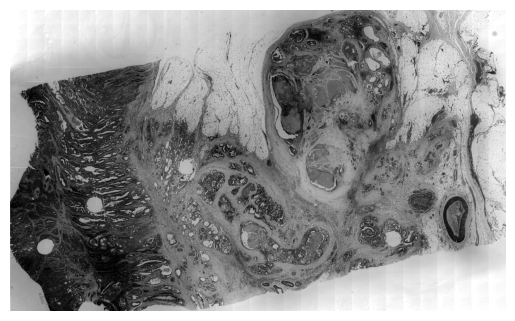

In [3]:
plt.imshow(1-cycif_image, cmap='gray')
plt.axis('off')
# plt.show()
# plt.savefig(f'/home/jupyter/Projects/cycif/images/WD-76845-{sample_number:03}_cycif_channel27.png', bbox_inches='tight')
plt.savefig(f'/home/jupyter/Projects/cycif/images/CRC{sample}_cycif_channel27.png', bbox_inches='tight')
import matplotlib.image
# # matplotlib.image.imsave(f'/home/jupyter/Projects/cycif/images/WD-76845-{sample_number:03}_cycif_channel27.png', cycif_image)
# matplotlib.image.imsave(f'/home/jupyter/Projects/cycif/images/CRC{sample}_cycif_channel27_hires.png', cycif_image)

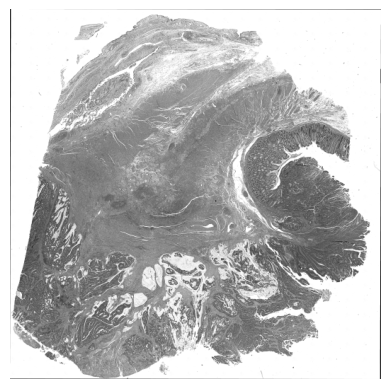

In [5]:
plt.imshow(np.mean(hne_image, axis=2), cmap='gray')
plt.axis('off')
plt.savefig(f'/home/jupyter/Projects/cycif/images/WD-76845-{sample_number:03}_nhe_gray.png', bbox_inches='tight')

In [ ]:
resize_ratio_hne = 0.01
cycif_to_hne_ratio = 2.0
sample_number = 96
cycif_sample = sample_number+1
# cycif_file = f'/home/jupyter/Data/CRC_Lin/WD-76845-{cycif_sample:03}.ome.tif'
# cells_file = f'/home/jupyter/Data/CRC_Lin/WD-76845-{cycif_sample:03}.csv'
sample = '15'
cells_file = f'/home/jupyter/Data/CRC_Lin/CRC{sample}_new_coordinates.csv'
cycif_file = f'/home/jupyter/Data/CRC_Lin/CRC{sample}.ome.tif' 

# prot = 'Ki67'
prot = 'PDL1'
W, z = rotate_coordinates_file(cells_file, image_shape = cycif_file, 
                            final_resize = cycif_to_hne_ratio * resize_ratio_hne, 
                                channel = prot, rotate_90clockwise = False)
z = np.log(z+1)
z = (z - z.mean())/z.std()
save = True #False

norm = 0.01
if norm is None:
    vmin = vmax = None
else:
    vmin = np.percentile(z, norm)
    vmax = np.percentile(z, 100 - norm)
plt.figure(figsize = (10,10))
# plt.figure(figsize = (14,9))
idx = (W[:,0]>=0) & (W[:,0]<=200) & (W[:,1]>=200) & (W[:,1]<=400)
W = W[idx]
z = z[idx]
g = plt.scatter(W[:,0], W[:,1], c=z, cmap='viridis', s=4, marker = 'o', linewidth=0, vmin = vmin, vmax = vmax)
# g = plt.scatter(W[:,0], W[:,1], c=z, cmap='viridis', s=1, marker = 'o', linewidth=0, vmin = vmin, vmax = vmax)
plt.gca().invert_yaxis()
# plt.gca().axis('off') 
if save:
    plt.show()
else:
    plt.savefig(f'/home/jupyter/Projects/cycif/images/WD-76845-{cycif_sample:03}_{prot}_scatter.png', bbox_inches='tight')

In [ ]:
save = True
resize_ratio_hne = 0.01
# for i in [1,6,13,19,24,28,33,38,43,48,53,58,63,68,73,77,83,85,90,96,101,105]:
for i in [24]:
    s_i = '%03d' % i
    s_j = '%03d' % (i+1)
    if os.path.exists(f'/home/jupyter/Data/CRC_Lin/WD-76845-{s_j}_new_coordinates.csv'):
        image = plt.imread(f'/home/jupyter/CycifPreprocess/ProcessedData/WD-76845-{s_i}_resize_{resize_ratio_hne}.ome.jpg')       
        W, _ = rotate_coordinates_file(f'/home/jupyter/Data/CRC_Lin/WD-76845-{s_j}_new_coordinates.csv', 
                                       image_shape = f'/home/jupyter/Data/CRC_Lin/WD-76845-{s_j}.ome.tif', 
                               final_resize = 2.0 * 1.0, 
                                   channel = 'Hoechst0', rotate_90clockwise = i==1)
        T = np.load(f'/home/jupyter/CycifPreprocess/ProcessedData/WD-76845-{s_j}.ome_affine_transform.npy')
        W = affine_transformation_coordinates(W, T, image_shape = np.array(image.shape[:2])/resize_ratio_hne, translation_resize = None, 
                                          image_resize = 2.0 * 1.0, 
                                              rotation_resize_ratio = 2.0 * 0.01)
        W = W*resize_ratio_hne
        plt.figure()
        plt.imshow(image)
        sns.scatterplot(x = W[:,0], y = W[:,1], s = 0.2, linewidth=0, alpha = 0.5, c='g')
        plt.axis('off')
        if save:
            plt.savefig(f'/home/jupyter/Projects/cycif/images/WD-76845-{s_i}_global_alignment.png', bbox_inches='tight')
        else:
            plt.show()
        df = pd.read_csv(f'/home/jupyter/Data/CRC_Lin/WD-76845-{s_j}_new_coordinates.csv')
        W = df[['Xt', 'Yt']].to_numpy()
        W = W*resize_ratio_hne*2.0/0.65
        plt.figure()
        plt.imshow(image)
        sns.scatterplot(x = W[:,0], y = W[:,1], s = 0.2, linewidth=0, alpha = 0.5, c='g')
        plt.axis('off')
        if save:
            plt.savefig(f'/home/jupyter/Projects/cycif/images/WD-76845-{s_i}_no_alignment.png', bbox_inches='tight')
        else:
            plt.show()
        W = df[['hne_X', 'hne_Y']].to_numpy()
        W = W*resize_ratio_hne
        plt.figure()
        plt.imshow(image)
        sns.scatterplot(x = W[:,0], y = W[:,1], s = 0.2, linewidth=0, alpha = 0.5, c='g')
        plt.axis('off')
        if save:
            plt.savefig(f'/home/jupyter/Projects/cycif/images/WD-76845-{s_i}_local_alignment.png', bbox_inches='tight')
        else:
            plt.show()

# Analyzing results

In [2]:
split_names = ['train', 'validation', 'test', 'crc_test']
sample_cols = ['Sample','x','y']
predicted_proteins = ['Keratin', 'Ki67', 'CD3', 'CD20', 'CD45RO', 'CD4', 'CD8a', 'CD68', 'CD163', 'FOXP3', 'PD1', 'PDL1', 'CD31', 'aSMA', 'Desmin', 'CD45']
label_col = [f'{s}.mean' for s in predicted_proteins]
patch_csvs = {
    'train': '/home/jupyter/CycifPreprocess/ProcessedData/sample_patches_measurements_with_cells_gating_channels_train.csv',
    'validation': '/home/jupyter/CycifPreprocess/ProcessedData/sample_patches_measurements_with_cells_gating_channels_val.csv',
    'test' : '/home/jupyter/CycifPreprocess/ProcessedData/sample_patches_measurements_with_cells_gating_channels_test.csv',
    'crc_test': '/home/jupyter/CycifPreprocess/ProcessedData/crc_sample_patches_measurements_with_cells_gating_channels.csv',
}

model_paths = {
    'ssl_vit8_mlp' : '/home/jupyter/Projects/cycif/logs/2023-08-15T12-28-44_ssl_vit_mlp8_16channels',
    'imagenet_resnet50' : '/home/jupyter/Projects/cycif/logs/2024-06-04T08-10-43_imagenet_resnet50_mlp_16channels',
    'channel_average_linear_reg': '/home/jupyter/Projects/cycif/logs/2023-08-15T12-40-26_channel_average_linear_reg_16channels',
}

In [3]:
measured_dfs = {}
samples = {}
predicted_dfs = {}
for s in patch_csvs:
    measured_dfs[s] = pd.read_csv(patch_csvs[s])
    measured_dfs[s] = measured_dfs[s][sample_cols + label_col]
    samples[s] = pd.unique(measured_dfs[s]['Sample'])
    predicted_dfs[s] = {}
    for mod in model_paths:
        if s != 'crc_test':
            prediction_mat = np.load(f'{model_paths[mod]}/{s}_predictions.npy')
        else:
            prediction_mat = np.load(f'{model_paths[mod]}/crc_test/test_predictions.npy')
        temp_df = measured_dfs[s].copy()
        temp_df.iloc[:,-len(label_col):] = prediction_mat
        predicted_dfs[s][mod] = temp_df
        print(s, measured_dfs[s].shape, mod, predicted_dfs[s][mod].shape)
        
corr_df = pd.DataFrame(columns=['Model', 'Split', 'Sample'] + label_col)
for s in patch_csvs:
    for mod in model_paths:
        model_folder_path = model_paths[mod]
        res_df = sample_corrs_from_dfs([measured_dfs[s], predicted_dfs[s][mod]], label_col, 
                                    #    save = f'{model_folder_path}/{s}_correlations.csv'
                                    # corr_func=scipy.stats.spearmanr,
                                       )
        print(s, mod)
        # print(res_df)
        res_df['Split'] = s
        res_df['Model'] = mod
        res_df = res_df[corr_df.columns]
        corr_df = pd.concat([corr_df, res_df], ignore_index= True)
corr_df_flat = pd.melt(corr_df, id_vars=['Model','Split','Sample'], 
        value_vars=label_col, var_name = 'Protein', value_name = 'Correlation')
corr_df_flat = pd.melt(corr_df, id_vars=['Model','Split','Sample'], 
        value_vars=label_col, var_name = 'Protein', value_name = 'Correlation')

if len(model_paths) == 2:
    corr_df_flat = corr_df_flat.replace({'ssl_vit8_mlp': 'SSL_MLP', 'channel_average_linear_reg': 'Baseline'})
elif len(model_paths) > 2:
    corr_df_flat = corr_df_flat.replace({'ssl_vit8_mlp': 'SSL_MLP', 'channel_average_linear_reg': 'Color_Lin_Reg', 'imagenet_resnet50': 'ResNet50'})
corr_df_flat = corr_df_flat.replace({'train': 'Train', 'validation': 'Validation', 'test': 'Test', 'crc_test': 'Other samples'})
corr_df_flat = corr_df_flat.replace({f'{p}.mean':p for p in predicted_proteins})
corr_df_flat = corr_df_flat.replace({s:f'CRC1-{int(float(s))}' for s in pd.unique(corr_df_flat['Sample']) if not s.startswith('CRC')})

train (1351680, 19) ssl_vit8_mlp (1351680, 19)
train (1351680, 19) imagenet_resnet50 (1351680, 19)
train (1351680, 19) channel_average_linear_reg (1351680, 19)
validation (388783, 19) ssl_vit8_mlp (388783, 19)
validation (388783, 19) imagenet_resnet50 (388783, 19)
validation (388783, 19) channel_average_linear_reg (388783, 19)
test (379142, 19) ssl_vit8_mlp (379142, 19)
test (379142, 19) imagenet_resnet50 (379142, 19)
test (379142, 19) channel_average_linear_reg (379142, 19)
crc_test (794166, 19) ssl_vit8_mlp (794166, 19)
crc_test (794166, 19) imagenet_resnet50 (794166, 19)
crc_test (794166, 19) channel_average_linear_reg (794166, 19)
train ssl_vit8_mlp
train imagenet_resnet50
train channel_average_linear_reg
validation ssl_vit8_mlp
validation imagenet_resnet50
validation channel_average_linear_reg
test ssl_vit8_mlp
test imagenet_resnet50
test channel_average_linear_reg
crc_test ssl_vit8_mlp
crc_test imagenet_resnet50
crc_test channel_average_linear_reg


In [20]:
for mod in ['SSL_MLP',  'Color_Lin_Reg', 'ResNet50']:
    print('------------', mod)
    print(corr_df_flat[(corr_df_flat.Model == mod) & (corr_df_flat.Split.isin(['Train','Validation','Test']))].describe())
    print(corr_df_flat[(corr_df_flat.Model == mod) & (corr_df_flat.Split.isin(['Train','Validation','Test'])) & (corr_df_flat.Protein == 'CD45')].describe())
    print(corr_df_flat[(corr_df_flat.Model == mod) & (corr_df_flat.Split == 'Test')].describe())

------------ SSL_MLP
       Correlation
count  1056.000000
mean      0.618962
std       0.169193
min      -0.338591
25%       0.521879
50%       0.643667
75%       0.742086
max       0.943581
       Correlation
count    66.000000
mean      0.624924
std       0.192963
min      -0.338591
25%       0.588743
50%       0.668575
75%       0.731233
max       0.823501
       Correlation
count   352.000000
mean      0.621978
std       0.178471
min      -0.338591
25%       0.522451
50%       0.647254
75%       0.755096
max       0.943581
------------ Color_Lin_Reg
       Correlation
count  1056.000000
mean      0.390601
std       0.208190
min      -0.316802
25%       0.240667
50%       0.382721
75%       0.559877
max       0.820827
       Correlation
count    66.000000
mean      0.195855
std       0.117635
min      -0.070288
25%       0.103535
50%       0.183707
75%       0.287338
max       0.441531
       Correlation
count   352.000000
mean      0.382722
std       0.226113
min      -0.316802
25

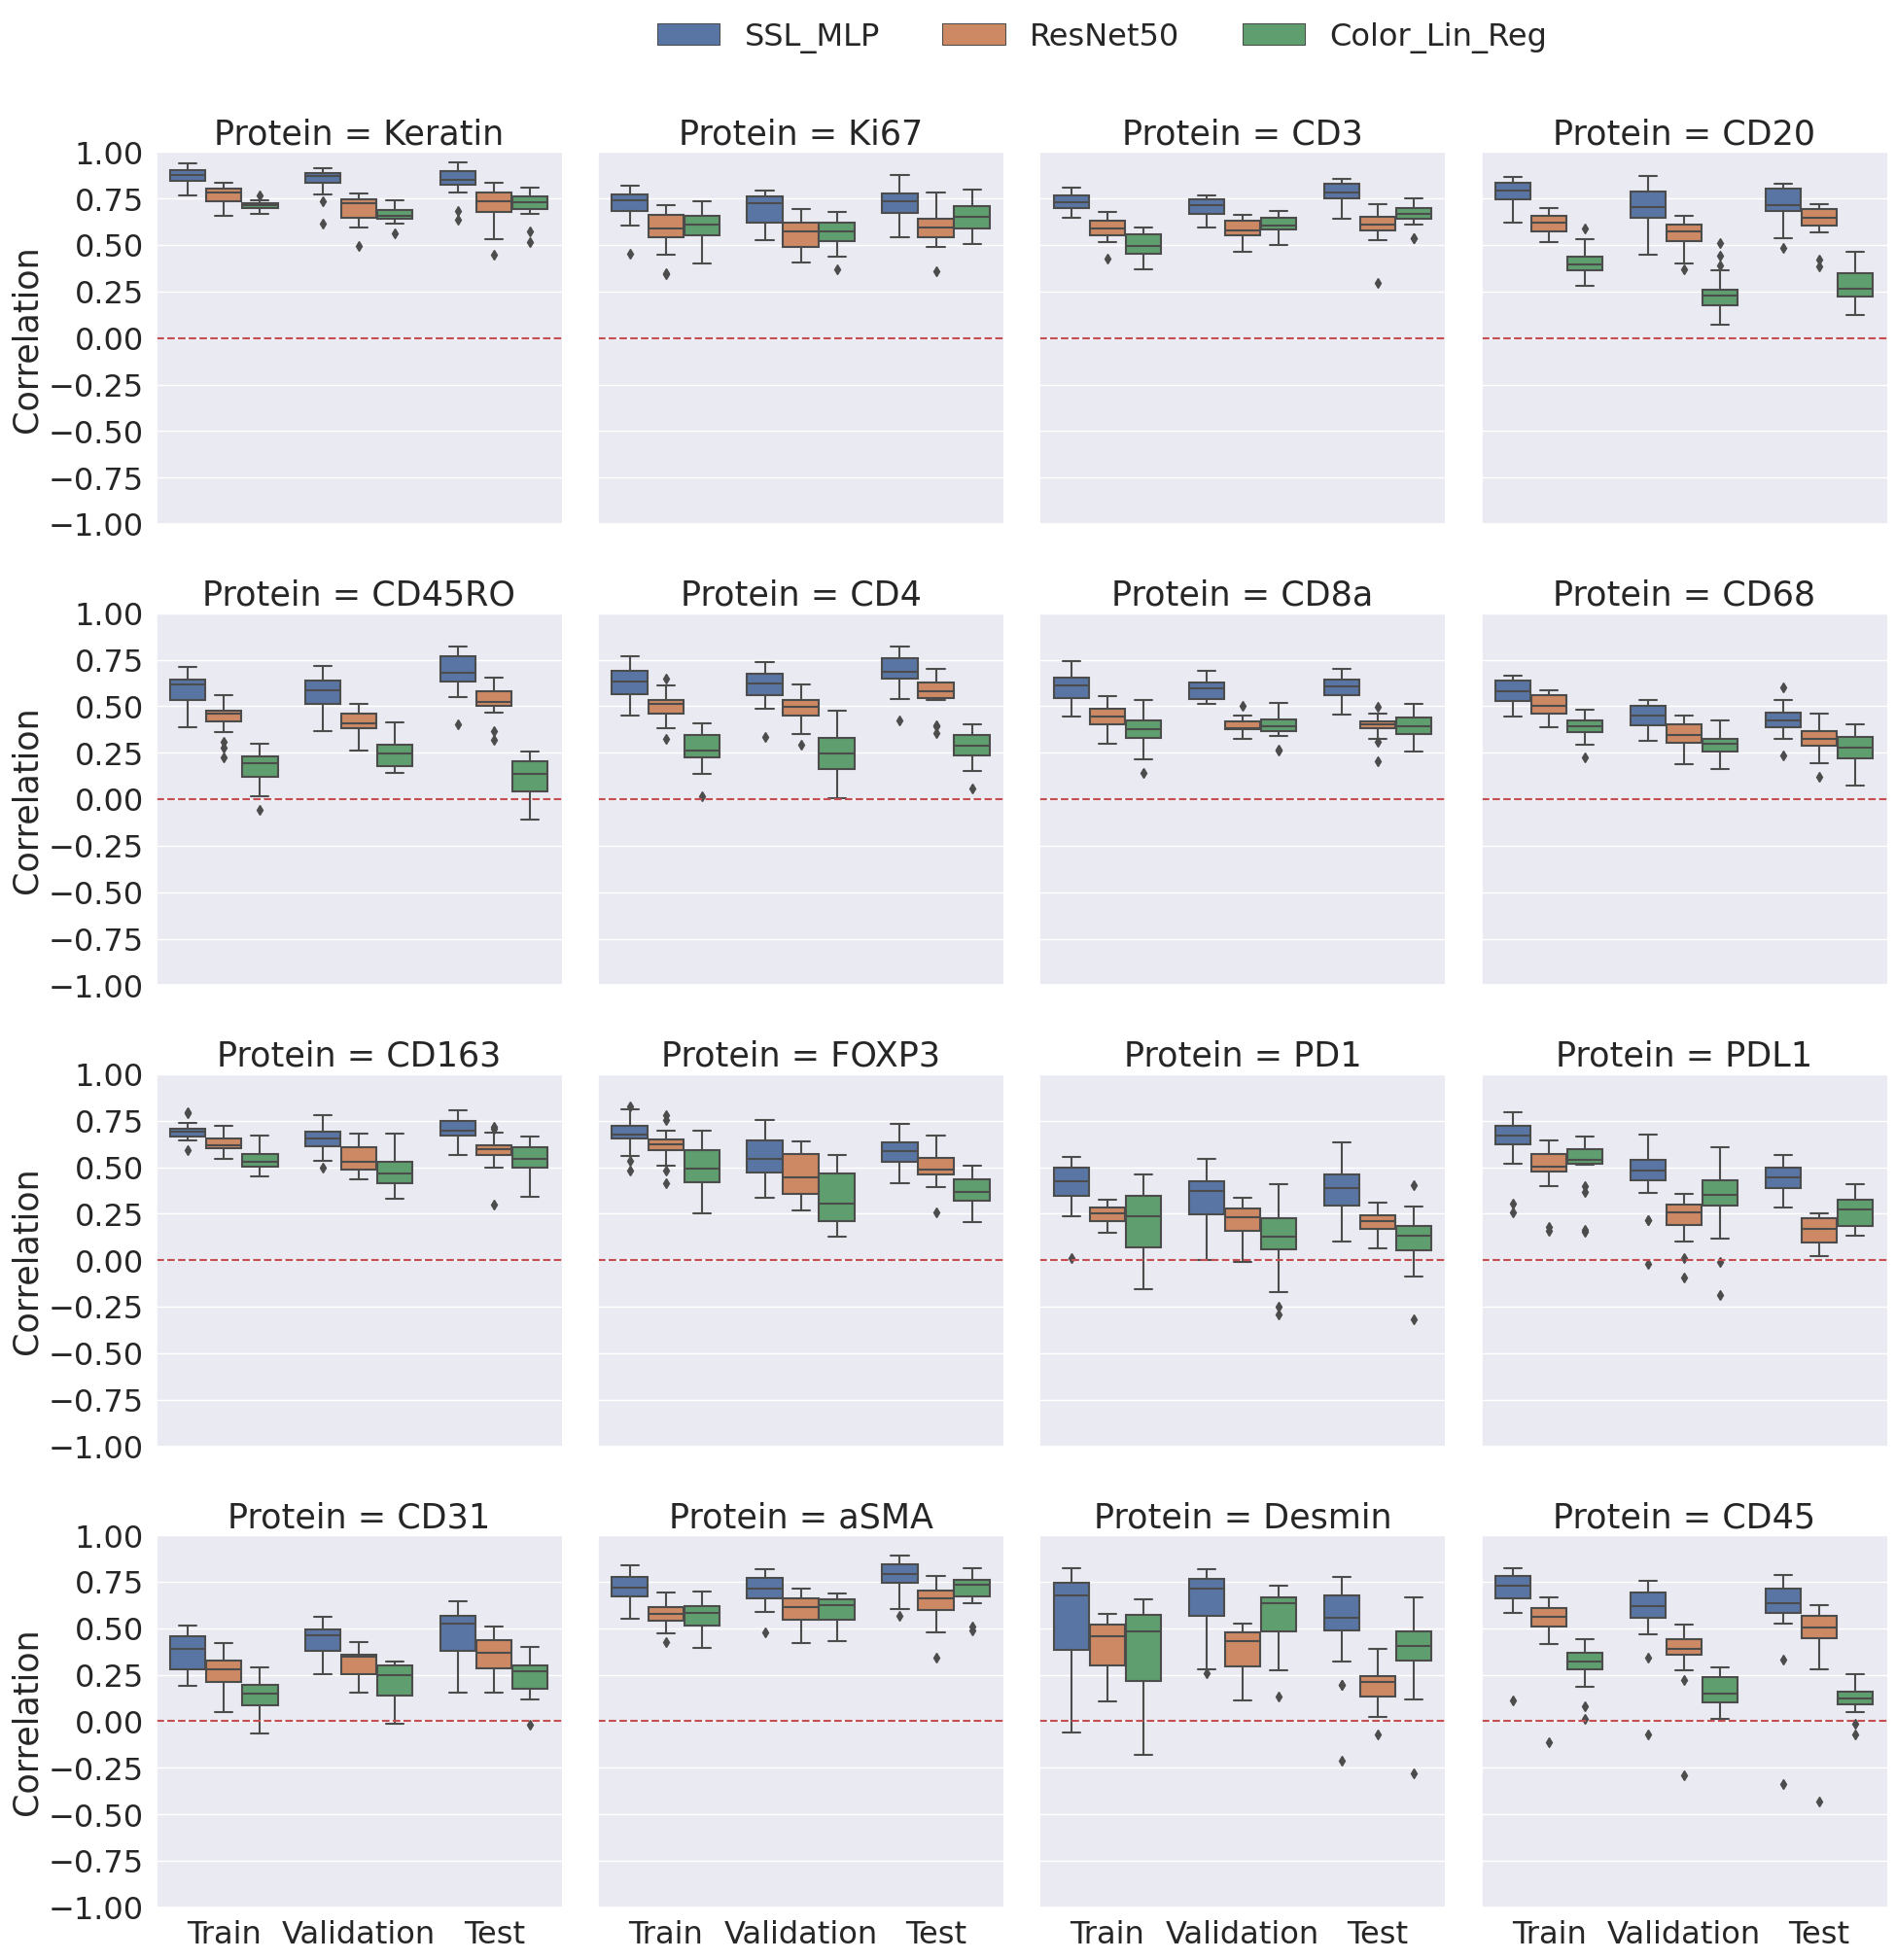

In [16]:
sns.set(font_scale=2.1)
which_plot = 'crc1_results' # 'test_vs_crc' #'crc1_results' 
save = False
if which_plot == 'crc1_results':
    g = sns.catplot(data=corr_df_flat[corr_df_flat['Split']!='Other samples'], x="Split", y="Correlation", hue = 'Model', col = 'Protein', kind="box", col_wrap = 4) # 8)
elif which_plot == 'test_vs_crc':
    g = sns.catplot(data=corr_df_flat[corr_df_flat.Split.isin(['Test', 'Other samples'])], x="Split", y="Correlation", hue = 'Model', col = 'Protein', kind="box", col_wrap = 4) # 8)
    g.set_xticklabels(['CRC01 test', 'CRC samples'], rotation=0)
g.set(ylim=(-1, 1), xlabel='')
for ax in g.axes:
    ax.axhline(0, ls='--', c='r')
sns.move_legend(g, "lower center",bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
sns.set(font_scale=1.0)
if save:
    plt.savefig(f'images/{which_plot}.pdf', bbox_inches='tight', pad_inches=0)

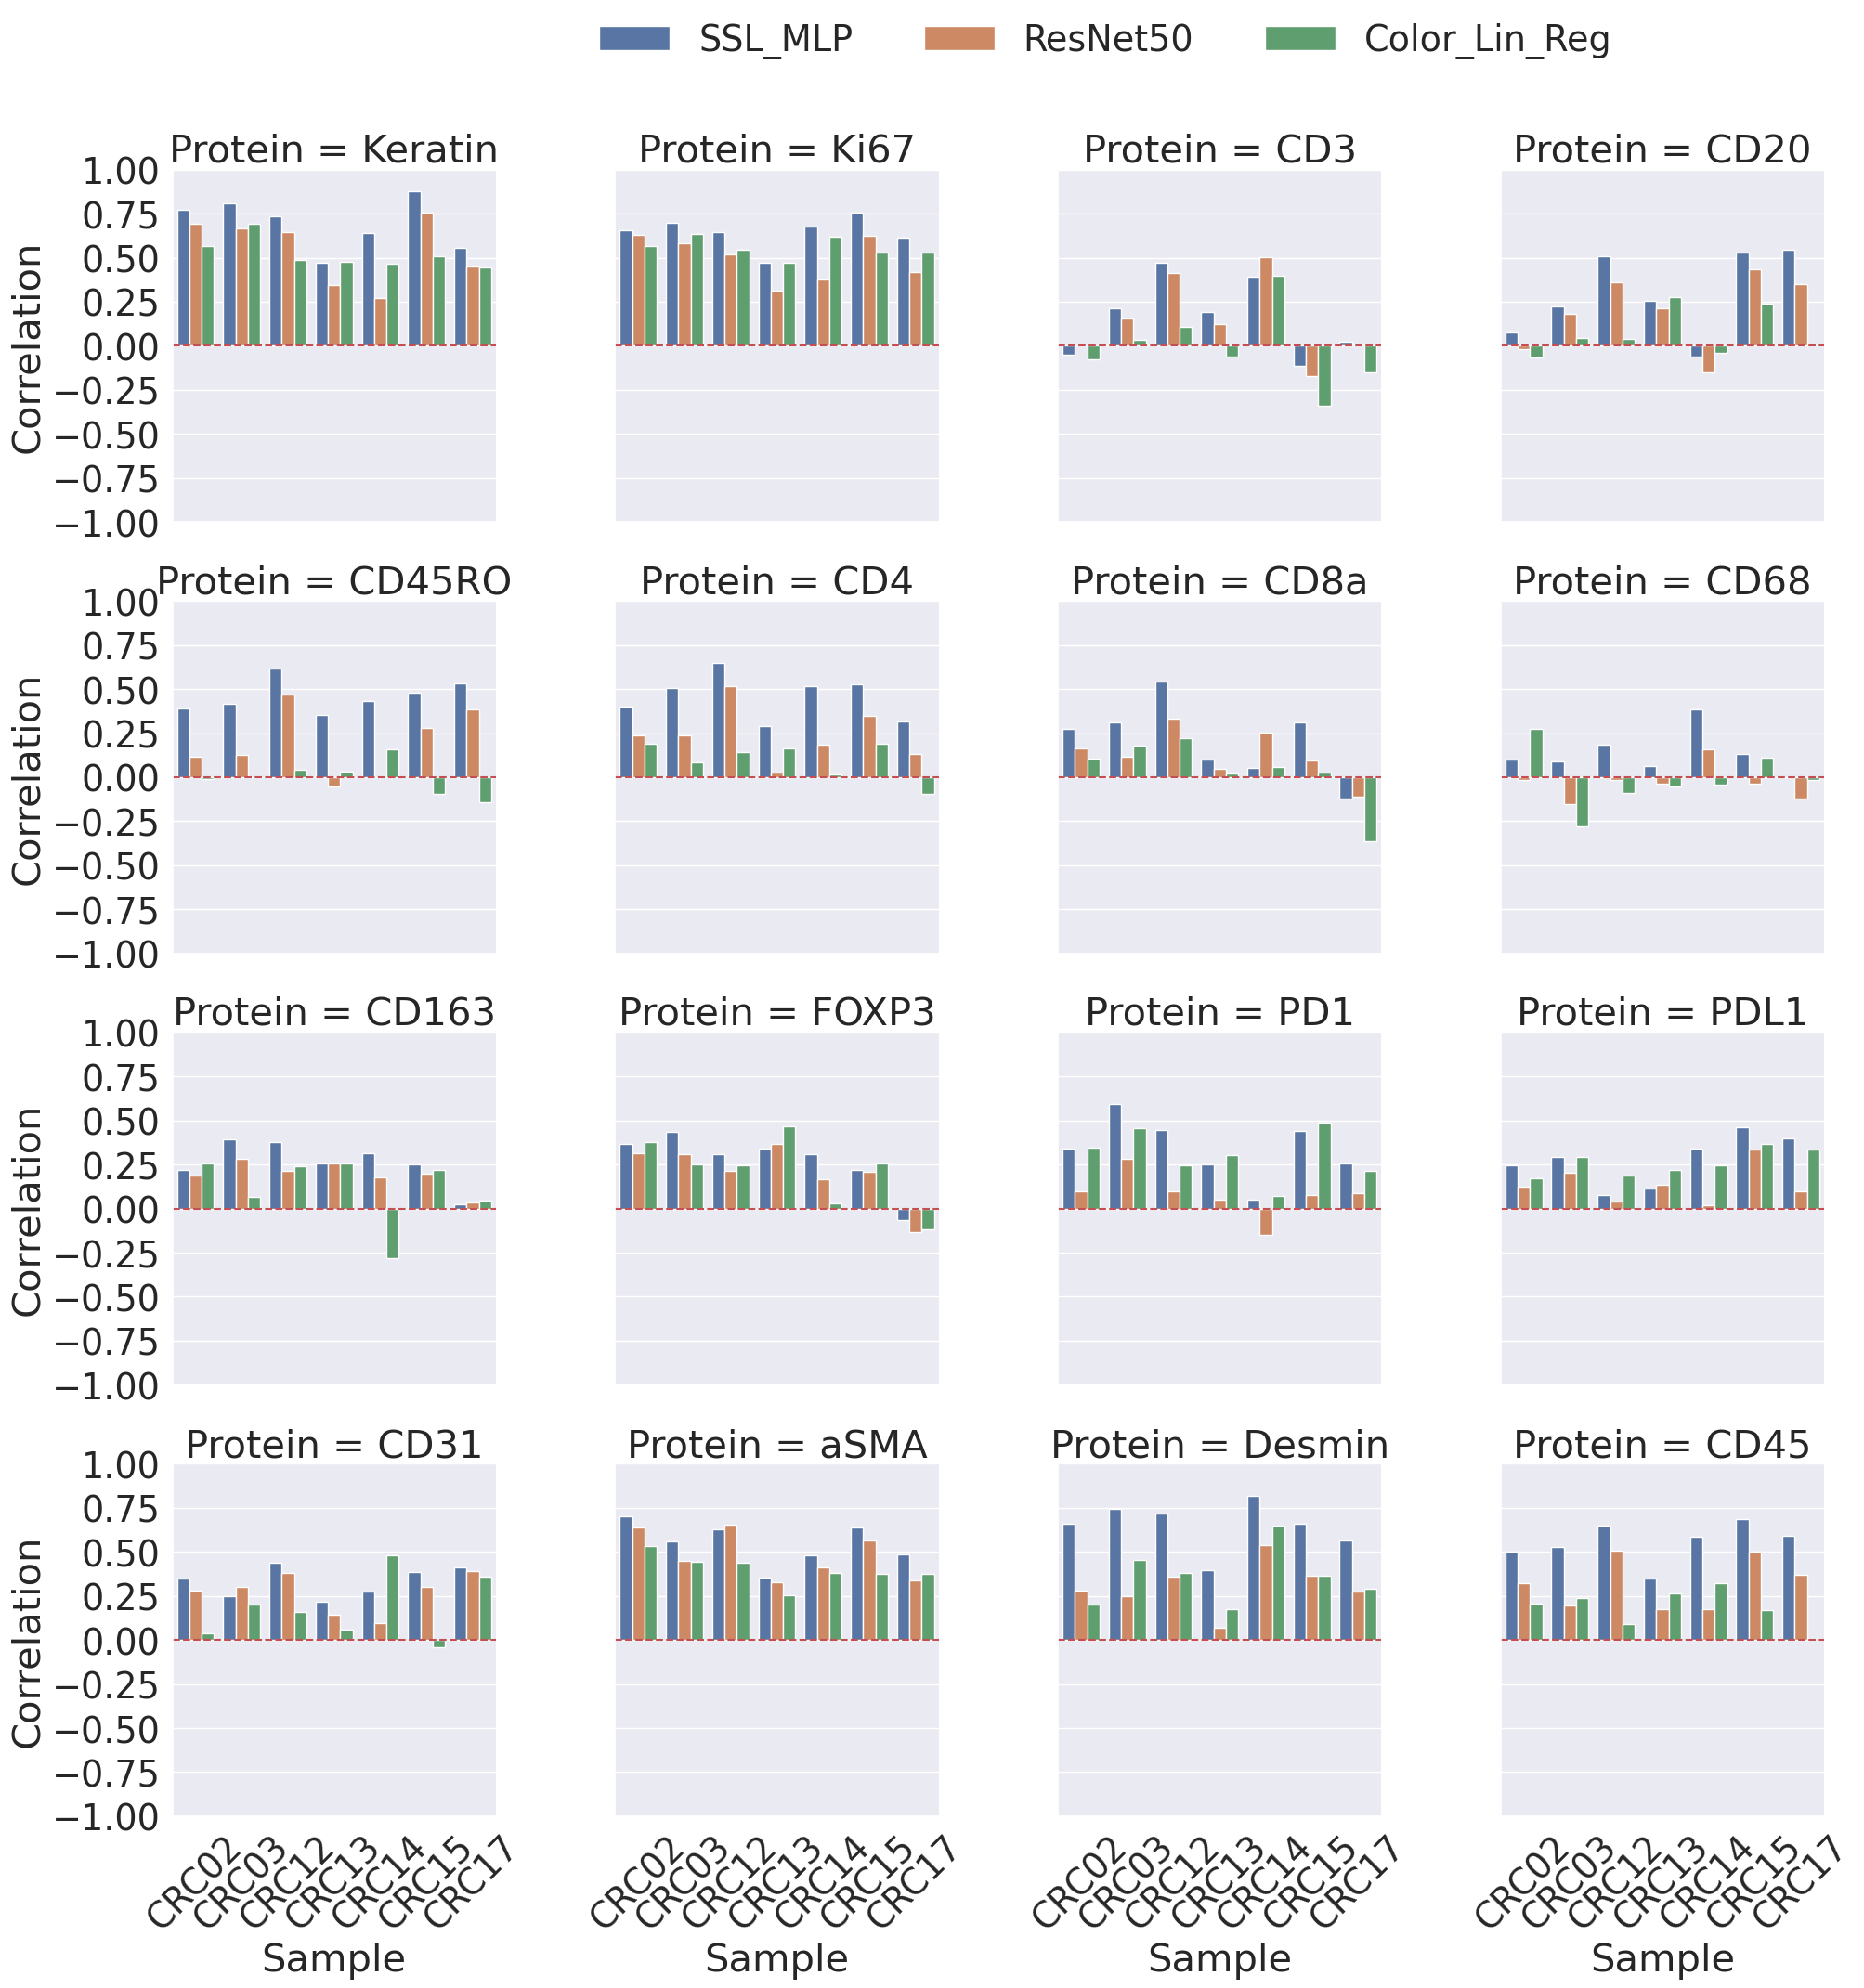

In [17]:
sns.set(font_scale=2.5)
# g = sns.catplot(data=corr_df_flat[corr_df_flat['Split']=='Other samples'], y="Correlation", hue = 'Model', col = 'Protein', col_wrap = 8)
g = sns.catplot(data=corr_df_flat[corr_df_flat['Split']=='Other samples'], x="Sample", y="Correlation", hue = 'Model', col = 'Protein', kind="bar", col_wrap = 4) # 8)
g.set_xticklabels([f'CRC{i:02}' for i in [2, 3, 12, 13, 14, 15, 17]], rotation=45)
g.set(ylim=(-1, 1))
for ax in g.axes:
    ax.axhline(0, ls='--', c='r')
sns.move_legend(g, "lower center",bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
sns.set(font_scale=1)
if save:
    plt.savefig('images/other_sample_results.pdf', bbox_inches='tight', pad_inches=0)

/opt/conda/envs/cycif/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/cycif/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/cycif/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


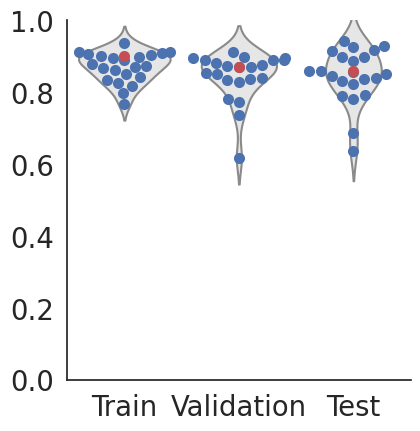

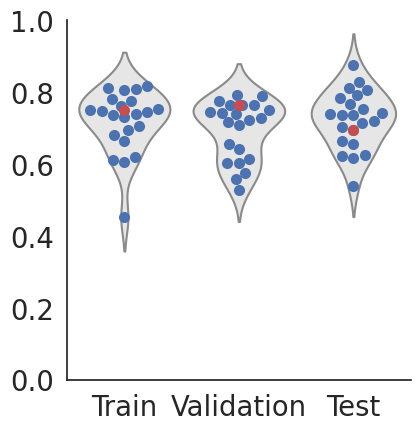

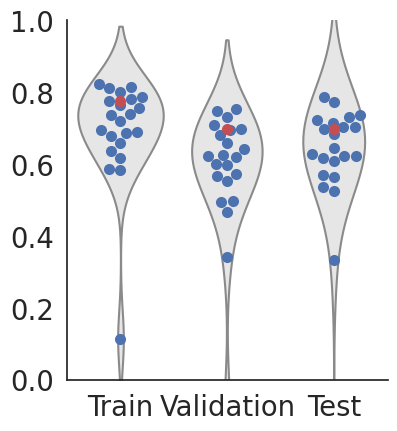

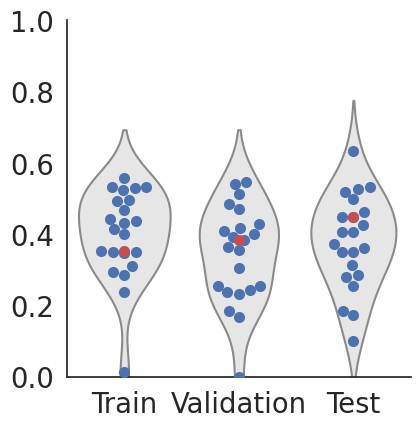

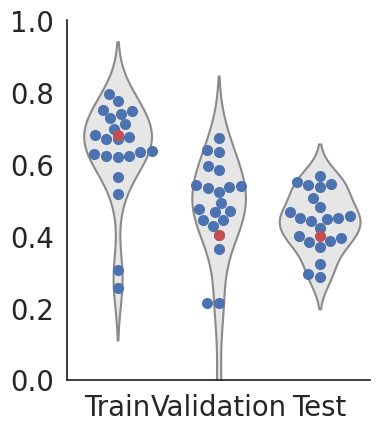

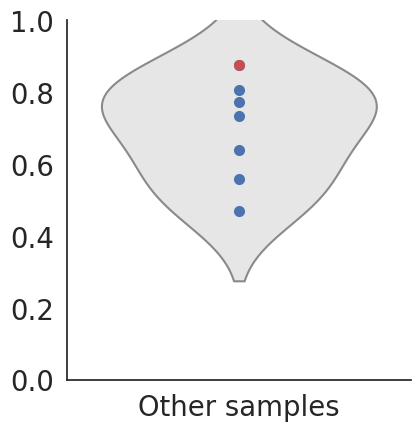

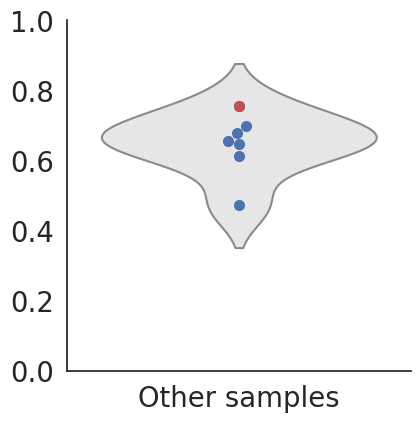

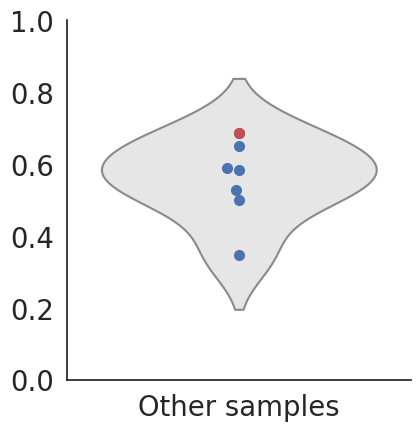

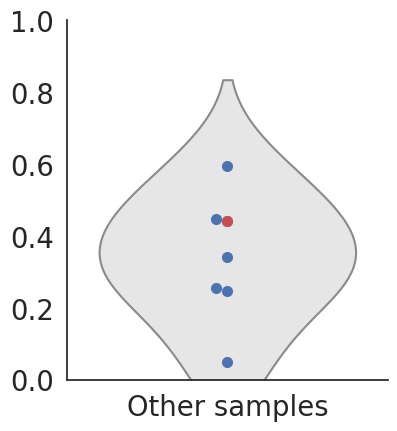

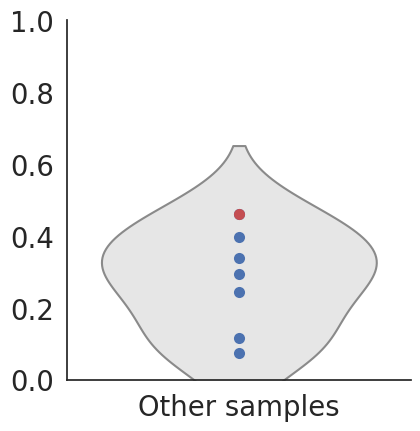

In [9]:
for Sample in ['CRC1-96', 'CRC15']:
    if Sample.startswith('CRC1-'):
        splits = ['Train', 'Validation','Test']
    else:
        splits = ['Other samples']
    sns.set(font_scale=1.8, style='white')
    for prot in ['Keratin', 'Ki67', 'CD45', 'PD1', 'PDL1']:
        g = sns.catplot(data=corr_df_flat[(corr_df_flat.Split.isin(splits)) & (corr_df_flat.Protein == prot) & (corr_df_flat.Model == 'SSL_MLP')], 
                        x="Split", y="Correlation", kind="violin", color=".9", inner=None)
        g.set(ylim=(0, 1), xlabel='', ylabel='')
        sns.swarmplot(data=corr_df_flat[(corr_df_flat.Split.isin(splits)) & (corr_df_flat.Protein == prot) & (corr_df_flat.Model == 'SSL_MLP')], 
                    x="Split", y="Correlation" ,size=8)
        sns.swarmplot(data=corr_df_flat[(corr_df_flat.Split.isin(splits)) & (corr_df_flat.Protein == prot) & (corr_df_flat.Model == 'SSL_MLP') & (corr_df_flat.Sample == Sample)], 
                    x="Split", y="Correlation" ,size=8 , c = 'r')
        g.set(xlabel='', ylabel='')
        plt.savefig(f'images/corr_{Sample}_{prot}.pdf', bbox_inches='tight', pad_inches=0)
    sns.set(font_scale=1)

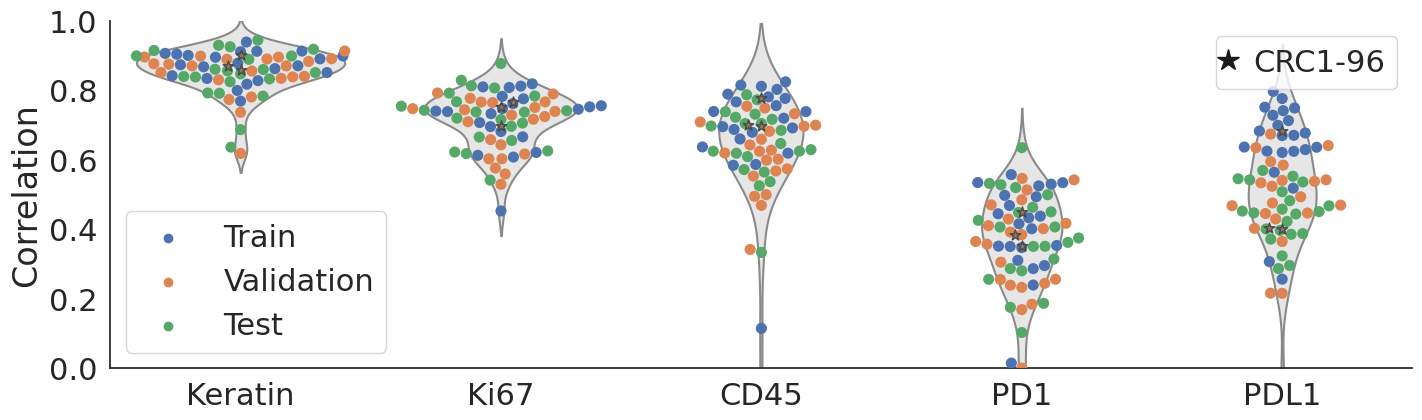

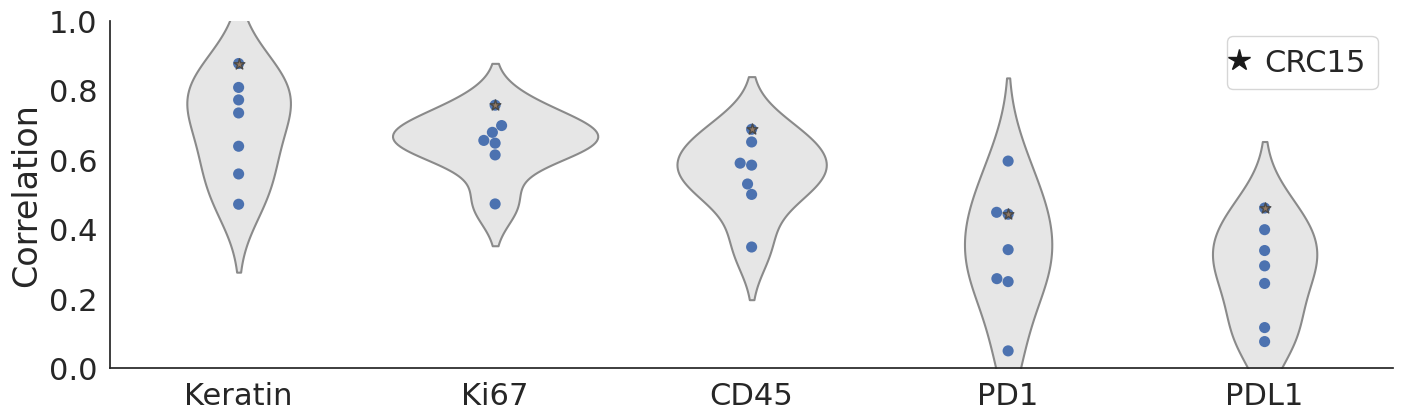

In [122]:
prot_to_plot = ['Keratin', 'Ki67', 'CD45', 'PD1', 'PDL1']
sns.set(font_scale=2, style='white')
save = False
marker_size = 8
for Sample in ['CRC1-96', 'CRC15']:
    if Sample.startswith('CRC1-'):
        splits = ['Train', 'Validation','Test']
    else:
        splits = ['Other samples']
    sub_df = corr_df_flat[(corr_df_flat.Split.isin(splits)) & (corr_df_flat.Protein.isin(prot_to_plot)) & (corr_df_flat.Model == 'SSL_MLP')]
    g = sns.catplot(data=sub_df, 
                            x="Protein", y="Correlation", kind="violin", color=".9", inner=None, aspect=3, order=prot_to_plot)
    g.set(ylim=(0, 1), xlabel='', ylabel='')
    sns.swarmplot(data=sub_df, 
                x="Protein", y="Correlation" , hue = 'Split', size=marker_size, order=prot_to_plot)
    sns.swarmplot(data=sub_df[(sub_df.Sample == Sample)], 
                        x="Protein", y="Correlation" ,size=marker_size, marker="*", linewidth=1, order=prot_to_plot)
    if Sample.startswith('CRC1-'):
        plt.gca().add_artist(g.ax.get_legend())
    else:
        plt.legend([],[], frameon=False)
    g.ax.legend(handles=[matplotlib.lines.Line2D([0], [0], marker='*', color='k', label=Sample, fillstyle='full',
                           markerfacecolor='k', markeredgecolor='k', markersize=2*marker_size, linestyle='none'),], 
                    loc='upper right', title=None, frameon=True, handlelength = 0.0,)
    g.set(xlabel='', ylabel='Correlation')
    if save:
        plt.savefig(f'images/corr_selected_prot_{Sample}.pdf', bbox_inches='tight', pad_inches=0)
    else:
        plt.show()

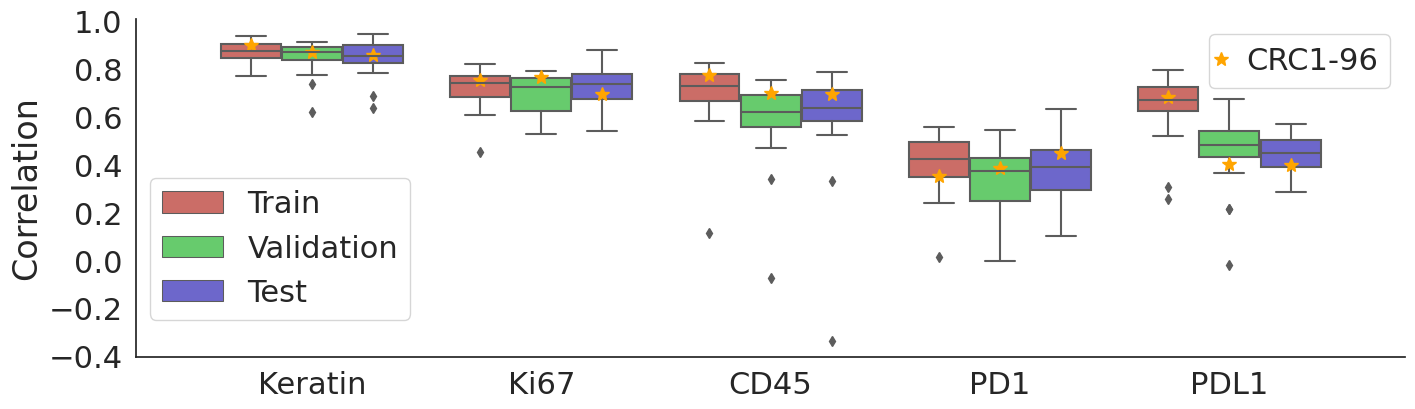

In [123]:
save = False
prot_to_plot = ['Keratin', 'Ki67', 'CD45', 'PD1', 'PDL1']
sns.set(font_scale=2, style='white')
save = False
splits = ['Train', 'Validation','Test']
sub_df = corr_df_flat[(corr_df_flat.Split.isin(splits)) & (corr_df_flat.Protein.isin(prot_to_plot)) & (corr_df_flat.Model == 'SSL_MLP')]
g = sns.catplot(data=sub_df, x="Protein", y="Correlation", hue = 'Split', kind="box",aspect=3, palette=sns.color_palette("hls", 3), order=prot_to_plot)
splits = ['Train', 'Validation','Test']
for i,split in enumerate(splits):
    temp = sub_df[(sub_df.Sample == 'CRC1-96') & (sub_df.Split == split)]
    a = np.array([temp[temp.Protein == prot]['Correlation'].to_numpy() for prot in prot_to_plot]).flatten()
    g.ax.plot(np.arange(0,len(prot_to_plot)) + 0.4 * (2.0*(i + 0.5)/(len(splits)) - 1.0), a, color='orange', marker = '*', linewidth=0, markersize=10)
sns.move_legend(g, "center left",bbox_to_anchor=(0.12, 0.45), frameon=True, title=None)
# plt.gca().add_artist(g.ax.get_legend())
g.ax.legend(handles=[matplotlib.lines.Line2D([0], [0], marker='*', color='orange', label='CRC1-96',
                           markerfacecolor='orange', markersize=10,),], 
                    loc='upper right', title=None, frameon=True, handlelength = 0.0,)
g.set(xlabel='', ylabel='Correlation')
if save:
    plt.savefig(f'images/corr_selected_prot_split_CRC1-96.pdf', bbox_inches='tight', pad_inches=0)
else:
    plt.show()
sns.set(font_scale=1)

       Correlation
count   352.000000
mean      0.621978
std       0.178471
min      -0.338591
25%       0.522451
50%       0.647254
75%       0.755096
max       0.943581
0.6472539439488234


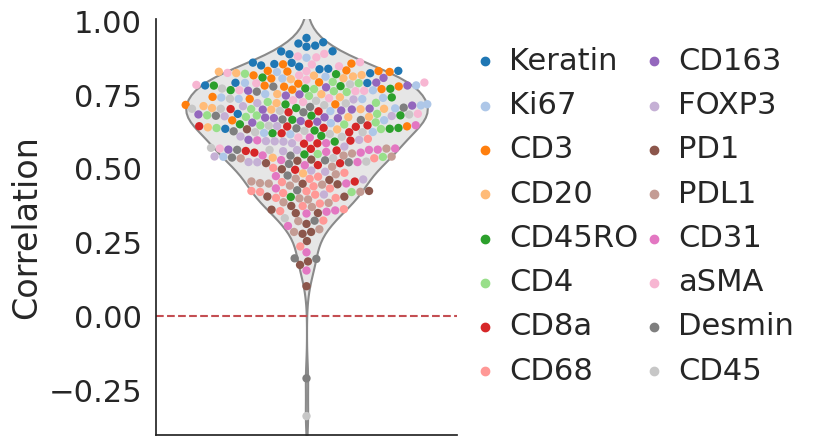

       Correlation
count   112.000000
mean      0.393749
std       0.225900
min      -0.119305
25%       0.250948
50%       0.395128
75%       0.558601
max       0.876257
0.39512829497525004


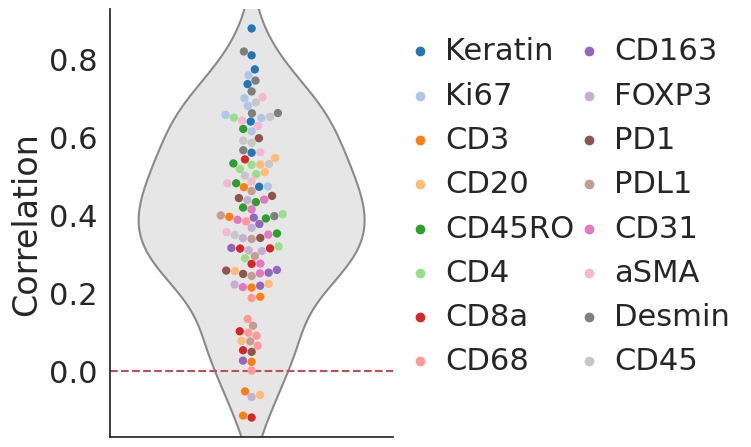

In [4]:
sns.set(font_scale=2, style='white')
save = False
for split in ['Test', 'Other samples']:
    sub_df = corr_df_flat[(corr_df_flat.Split == split) & (corr_df_flat.Model == 'SSL_MLP')]
    print(sub_df.describe())
    print(np.median(sub_df['Correlation']))
    g = sns.catplot(data=sub_df, y="Correlation", kind="violin", color=".9", inner=None, aspect=1)
    g =  sns.swarmplot(data=sub_df, 
                hue="Protein", y="Correlation" , size=6, palette='tab20')
    # g.axes.axhline(np.median(sub_df['Correlation']), ls='--', c='k')
    g.axes.axhline(0, ls='--', c='r')
    # sns.move_legend(
    #     g, "lower center",
    #     bbox_to_anchor=(.5, 1), ncol=8, title=None, frameon=False,
    # )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False,ncol=2, labelspacing = 0.5, handlelength = 0.0, columnspacing = 0.5)
    if save:
        plt.savefig(f'images/corr_all_prot_{split}.pdf', bbox_inches='tight', pad_inches=0)
    else:
        plt.show()

/opt/conda/envs/cycif/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/cycif/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


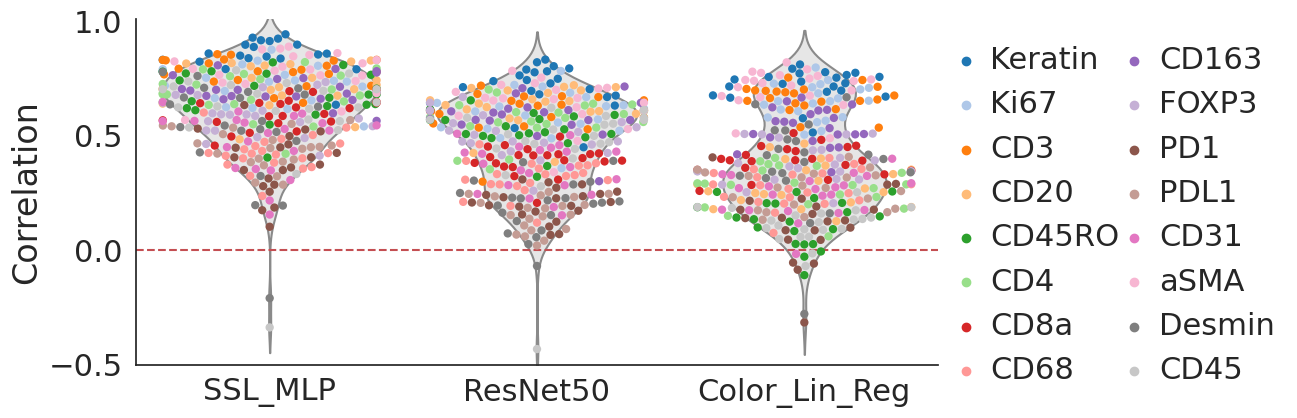

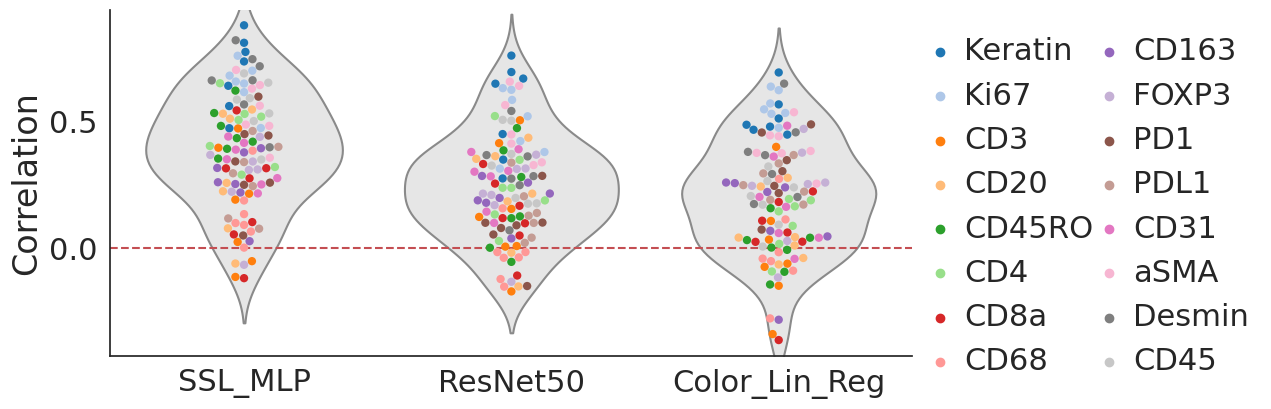

In [15]:
sns.set(font_scale=2.0, style='white')
save = False
for split in ['Test', 'Other samples']:
    sub_df = corr_df_flat[(corr_df_flat.Split == split)]
    g = sns.catplot(data=sub_df, x = 'Model', y="Correlation", kind="violin", color=".9", inner=None, aspect=2)
    g = sns.swarmplot(data=sub_df, x = 'Model', y="Correlation", hue="Protein", size=6, palette='tab20')
    g.set(xlabel='', ylabel='Correlation')
    g.axes.axhline(0, ls='--', c='r')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False,ncol=2, labelspacing = 0.5, handlelength = 0.0, columnspacing = 0.5)
    plt.show()

# Plot spatial expression

In [118]:
from eval_utils import *
save = False
for sample in [96.0, 'CRC15']:
    if not str(sample).startswith('CRC'):
        measurements_df = pd.concat([measured_dfs['train'], measured_dfs['validation'], measured_dfs['test']])
        baseline_prediction_df = pd.concat([predicted_dfs['train']['channel_average_linear_reg'], predicted_dfs['validation']['channel_average_linear_reg'], predicted_dfs['test']['channel_average_linear_reg']])
        model_prediction_df = pd.concat([predicted_dfs['train']['ssl_vit8_mlp'], predicted_dfs['validation']['ssl_vit8_mlp'], predicted_dfs['test']['ssl_vit8_mlp']])
        figsize = (6 + 1,6)
        orientation='vertical'
        rotate_cbar_ticks = 90
    else:
        measurements_df = measured_dfs['crc_test']
        baseline_prediction_df = predicted_dfs['crc_test']['channel_average_linear_reg']
        model_prediction_df = predicted_dfs['crc_test']['ssl_vit8_mlp']
        figsize = (7,4.5 + 1) # (7+1,4.5)
        orientation='horizontal'
        rotate_cbar_ticks = None
    for prot in ['Keratin', 'Ki67', 'CD45', 'PD1', 'PDL1']:
        save_file = f'images/measured_{sample}_{prot}.pdf' if save else None
        plot_scatter_from_df(measurements_df, prot, sample = sample, 
                             axis = False, figsize = figsize, marker = 's', s=1, zscore = True, norm = 1, colorbar = True, cmap = 'viridis',
                             show = not save, orientation = orientation, save = save_file, rotate_cbar_ticks = rotate_cbar_ticks)
        # plot_scatter_from_df(baseline_prediction_df,
        #                      prot, sample = sample, axis = False, figsize = figsize, marker = 's', s=1, zscore = True, norm = 1)
        save_file = f'images/predicted_{sample}_{prot}.pdf' if save else None
        plot_scatter_from_df(model_prediction_df, prot, sample = sample, 
                             axis = False, figsize = figsize, marker = 's', s=1, zscore = True, norm = 1, colorbar = True, cmap = 'viridis',
                             show = not save, orientation = orientation, save = save_file, rotate_cbar_ticks = rotate_cbar_ticks)
        # plot_scatter_from_df(measurements_df,
        #                      prot, sample = sample, axis = False, figsize = figsize, marker = 's', s=1, zscore = True, #norm = 1, 
        #                      df_for_delta= model_prediction_df, colorbar = True, cmap='bwr')

-1.0891604843658111 2.036106932486581
-1.262105595021604 1.688902278892698
-1.9193068828645727 2.145087361969847
-2.0134276292140605 1.4141832450435243
-1.512873190877984 3.0560011161166525
-1.1954079469710783 2.9669902896347056
-2.512834886593431 2.5909770408203783
-1.9971309205870083 2.9395655940473944
-1.7335275379877193 3.424864124208339
-1.4069914940776642 2.011453527195444
-1.008798825216506 2.1975449491850507
-1.309328590227535 2.3343849602147495
-1.4123719178147318 2.554597832183235
-3.1786496466320013 2.096990921068374
-1.3549980956012835 2.871240498681082
-1.7746282103317739 3.6218451884171152
-1.7950413774891663 2.4193113272094062
-1.9283473040842272 3.4460400974762773
-2.017208789018988 2.9485225986149968
-1.1722393494694785 2.3291169876959197


# Anaylze model results

In [44]:
all_measurements_df = pd.DataFrame(columns = list(measured_dfs['train'].columns)+['Split'])
all_predicted_df = pd.DataFrame(columns = list(measured_dfs['train'].columns)+['Split'])
for t in ['train','validation','test','crc_test']:
    df = measured_dfs[t].copy()
    df['Split'] = t
    all_measurements_df = pd.concat([all_measurements_df, df])
    df = predicted_dfs[t]['ssl_vit8_mlp'].copy()
    df['Split'] = t
    all_predicted_df = pd.concat([all_predicted_df, df])
all_measurements_df = all_measurements_df.rename(columns={f'{p}.mean':f'{p} measured' for p in predicted_proteins})
all_predicted_df = all_predicted_df.rename(columns={f'{p}.mean':f'{p} predicted' for p in predicted_proteins})
measurements_and_predicted_df = all_measurements_df.join(all_predicted_df.drop(columns=['Sample', 'x', 'y', 'Split']))
    

## Quantile plots (obselete)

In [ ]:
prot = 'Ki67'
# prot = 'CD45'
# prot = 'PD1'
sample  = 96.0
plt.figure(figsize=(10,10))
q = 0.005 #0.01
xlim = measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} measured'].quantile(q), measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} measured'].quantile(1-q)
ylim = measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} predicted'].quantile(q), measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} predicted'].quantile(1-q)
sns.jointplot(data=measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample], 
              x=f'{prot} measured', y=f'{prot} predicted', hue="Split", 
              linewidth = 0, s=0.1, kind="kde",
              xlim = xlim, ylim = ylim)

plt.show()

In [ ]:
# prot = 'Ki67'
# prot = 'CD45'
prot = 'PD1'
prot = 'PDL1'
# sample = 96.0
sample = 'CRC15'
plt.figure(figsize=(10,10))
q = 0.001
if q is None:
    xlim = measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} measured'].min(), measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} measured'].max()
    ylim = measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} predicted'].min(), measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} predicted'].max()
else:
    xlim = measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} measured'].quantile(q), measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} measured'].quantile(1-q)
    ylim = measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} predicted'].quantile(q), measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample][f'{prot} predicted'].quantile(1-q)
jointlim = min(xlim[0],ylim[0]), max(xlim[1],ylim[1])
g = sns.JointGrid(data=measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample], 
                  x=f'{prot} measured', y=f'{prot} predicted', 
                  hue="Split", hue_order = ['test','validation','train'] if not str(sample).startswith('CRC') else None,
                  xlim = jointlim, ylim = jointlim)
g.plot_marginals(sns.kdeplot)
sns.lineplot(x=np.arange(jointlim[0],jointlim[1],step=0.1),y=np.arange(jointlim[0],jointlim[1],step=0.1),
            color='r', linestyle='dashed',
             ax=g.ax_joint)
if not str(sample).startswith('CRC'):
    sns.kdeplot(data=measurements_and_predicted_df[(measurements_and_predicted_df.Sample == sample) & (measurements_and_predicted_df.Split == 'train')], 
                    x=f'{prot} measured', y=f'{prot} predicted', hue="Split", hue_order = ['test','validation','train'], alpha = 0.5, ax=g.ax_joint)
    sns.kdeplot(data=measurements_and_predicted_df[(measurements_and_predicted_df.Sample == sample) & (measurements_and_predicted_df.Split == 'validation')], 
                    x=f'{prot} measured', y=f'{prot} predicted', hue="Split", hue_order = ['test','validation','train'], alpha = 0.5, ax=g.ax_joint)
    sns.kdeplot(data=measurements_and_predicted_df[(measurements_and_predicted_df.Sample == sample) & (measurements_and_predicted_df.Split == 'test')], 
                    x=f'{prot} measured', y=f'{prot} predicted', hue="Split", hue_order = ['test','validation','train'], ax=g.ax_joint)
else:
    sns.kdeplot(data=measurements_and_predicted_df[(measurements_and_predicted_df.Sample == sample)], 
                    x=f'{prot} measured', y=f'{prot} predicted', ax=g.ax_joint)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(data=measurements_and_predicted_df[measurements_and_predicted_df.Sample == sample], 
              x=f'{prot} measured', y=f'{prot} predicted', hue="Split", 
              linewidth = 0, s=0.1, xlim = xlim, ylim = ylim)

plt.show()

## Spatial correlations (obselete)

In [ ]:
sample = 24.0
# sample = 'CRC15'
prot = 'Keratin'
# prot = 'Ki67'
# prot = 'CD45'
# prot = 'PD1'
if not str(sample).startswith('CRC'):
    measurements_df = pd.concat([measured_dfs['train'], measured_dfs['validation'], measured_dfs['test']])
    baseline_prediction_df = pd.concat([predicted_dfs['train']['channel_average_linear_reg'], predicted_dfs['validation']['channel_average_linear_reg'], predicted_dfs['test']['channel_average_linear_reg']])
    model_prediction_df = pd.concat([predicted_dfs['train']['ssl_vit8_mlp'], predicted_dfs['validation']['ssl_vit8_mlp'], predicted_dfs['test']['ssl_vit8_mlp']])
else:
    measurements_df = measured_dfs['crc_test']
    baseline_prediction_df = predicted_dfs['crc_test']['channel_average_linear_reg']
    model_prediction_df = predicted_dfs['crc_test']['ssl_vit8_mlp']

measurements_sample_df = measurements_df[measurements_df.Sample == sample]
model_prediction_sample_df = model_prediction_df[model_prediction_df.Sample == sample]

k = 200
_, indices = get_knn(measurements_df[measurements_df.Sample == sample], k = k)
corrs_list = []
line_args_list = []
prot_colors = {'Keratin':'r', 'aSMA':'b', 'FOXP3':'g'}
sample_dfs = {'Measured':measurements_sample_df, 'Predicted':model_prediction_sample_df}
linestyles = {'Measured':'--', 'Predicted':'-'}
for prot in prot_colors:
    for s in sample_dfs:
        corrs = spatial_corrs_from_dfs(sample_dfs[s], prot, indices = indices)
        corrs_list.append(corrs)
        line_args_list.append({'label':f'{s} {prot}', 'linestyle':linestyles[s], 'color':prot_colors[prot]})
plot_multiple_corrs(corrs_list, title = f'Sample {sample} spatial correlations',
                    line_args_list = line_args_list)

In [ ]:
k = 200
_, indices = get_knn(measurements_df[measurements_df.Sample == sample], k = k)
corrs_list = []
line_args_list = []
prot_colors = {'Keratin':'r', 'aSMA':'b', 'FOXP3':'g'}
for prot in prot_colors:
    corrs = spatial_corrs_from_dfs(measurements_sample_df, prot, df2 = model_prediction_sample_df, indices = indices)
    corrs_list.append(corrs)
    line_args_list.append({'label':f'{prot}', 'linestyle':'-', 'color':prot_colors[prot]})
plot_multiple_corrs(corrs_list, title = f'Sample {sample}: Measured vs. Predicted spatial correlations',
                    line_args_list = line_args_list)

In [ ]:
k = 200
_, indices = get_knn(measurements_df[measurements_df.Sample == sample], k = k)
corrs_list = []
line_args_list = []
prot_pair_colors = {('PD1', 'PDL1'):'k'}
sample_dfs = {'Measured':measurements_sample_df, 'Predicted':model_prediction_sample_df}
linestyles = {'Measured':'--', 'Predicted':'-'}
for prot1, prot2 in prot_pair_colors:
    for s in sample_dfs:
        corrs = spatial_corrs_from_dfs(sample_dfs[s], prot1, col2 = prot2, indices = indices)
        corrs_list.append(corrs)
        line_args_list.append({'label':f'{s} {prot1}~{prot1}', 'linestyle':linestyles[s], 'color':prot_pair_colors[prot1, prot2]})
plot_multiple_corrs(corrs_list, title = f'Sample {sample} spatial cross correlations',
                    line_args_list = line_args_list)

# Top k accuracy

In [45]:
sample = 96.0 #24.0
measurements_df = pd.concat([measured_dfs['train'], measured_dfs['validation'], measured_dfs['test'], measured_dfs['crc_test']])
baseline_prediction_df = pd.concat([predicted_dfs['train']['channel_average_linear_reg'], predicted_dfs['validation']['channel_average_linear_reg'], predicted_dfs['test']['channel_average_linear_reg'],predicted_dfs['crc_test']['channel_average_linear_reg']])
model_prediction_df = pd.concat([predicted_dfs['train']['ssl_vit8_mlp'], predicted_dfs['validation']['ssl_vit8_mlp'], predicted_dfs['test']['ssl_vit8_mlp'], predicted_dfs['crc_test']['ssl_vit8_mlp']])

# measurements_sample_df = measurements_df[measurements_df.Sample == sample]
# model_prediction_sample_df = model_prediction_df[model_prediction_df.Sample == sample]

# plot_gmm_expression(measurements_sample_df, ['PD1' , 'PDL1', 'CD45', 'FOXP3'] )
# for i in range(0,len(predicted_proteins),4):
#     plot_gmm_expression(measurements_sample_df, predicted_proteins[i:min(i+4,len(predicted_proteins))] )
# problematic = ['CD3', 'CD20' , 'CD8a', 'CD68', 'FOXP3', 'PD1', 'PDL1']
# for i in range(0,len(problematic),4):
#     plot_gmm_expression(measurements_sample_df, problematic[i:min(i+4,len(problematic))] )
# _ = quantize_expression_df(measurements_sample_df, ['PD1' , 'PDL1'])
# measurements_sample_df_quant, _ = quantize_expression_df(measurements_sample_df)
# model_prediction_sample_df_quant, _ = quantize_expression_df(model_prediction_sample_df)


In [ ]:
# q = 0.2
n = 5
for sample in [96.0, 'CRC15']:
    print('Sample', sample, '-----------------------------------')
    sample_measurements_df = measurements_df[measurements_df.Sample == sample]
    sample_predicted_df = model_prediction_df[model_prediction_df.Sample == sample]
    for prot in ['Ki67.mean', 'CD45.mean', 'PD1.mean', 'PDL1.mean']:
        print('Marker', prot)
        for i in range(n):
            i_n = float(i)/n
            i_1_n = float(i+1)/n
            measurements_idx = (sample_measurements_df[prot] >= sample_measurements_df[prot].quantile(i_n)) & (sample_measurements_df[prot] <= sample_measurements_df[prot].quantile(i_1_n))
            predicted_idx = (sample_predicted_df[prot] >= sample_predicted_df[prot].quantile(i_n)) & (sample_predicted_df[prot] <= sample_predicted_df[prot].quantile(i_1_n))
            print(i,i_n,i_1_n,sum(measurements_idx & predicted_idx)/sum(measurements_idx))

In [47]:
step = 0.1
top_k_acc = pd.DataFrame(columns = ['Sample', 'Marker', 'Top%', 'Accuracy'])
for sample in pd.unique(measurements_df.Sample):
    sample_measurements_df = measurements_df[measurements_df.Sample == sample]
    sample_predicted_df = model_prediction_df[model_prediction_df.Sample == sample]
    for prot in predicted_proteins:
        col = f'{prot}.mean'
        for p in np.arange(step,1,step):
            measurements_idx = sample_measurements_df[col] >= sample_measurements_df[col].quantile(1-p)
            predicted_idx = sample_predicted_df[col] >= sample_predicted_df[col].quantile(1-p)
            acc = sum(measurements_idx & predicted_idx)/sum(measurements_idx)
            top_k_acc.loc[len(top_k_acc)] = [sample, prot, int(100*p), acc]
# top_k_acc.to_csv('images/top_k_acc.csv', index = False)

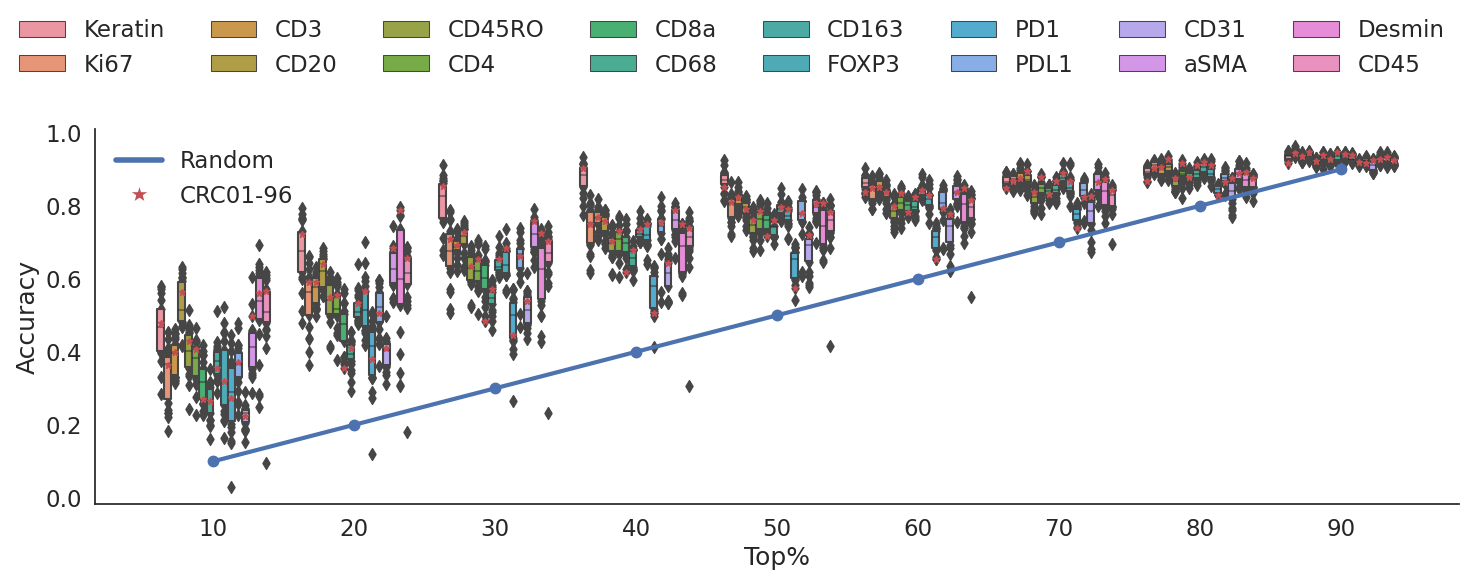

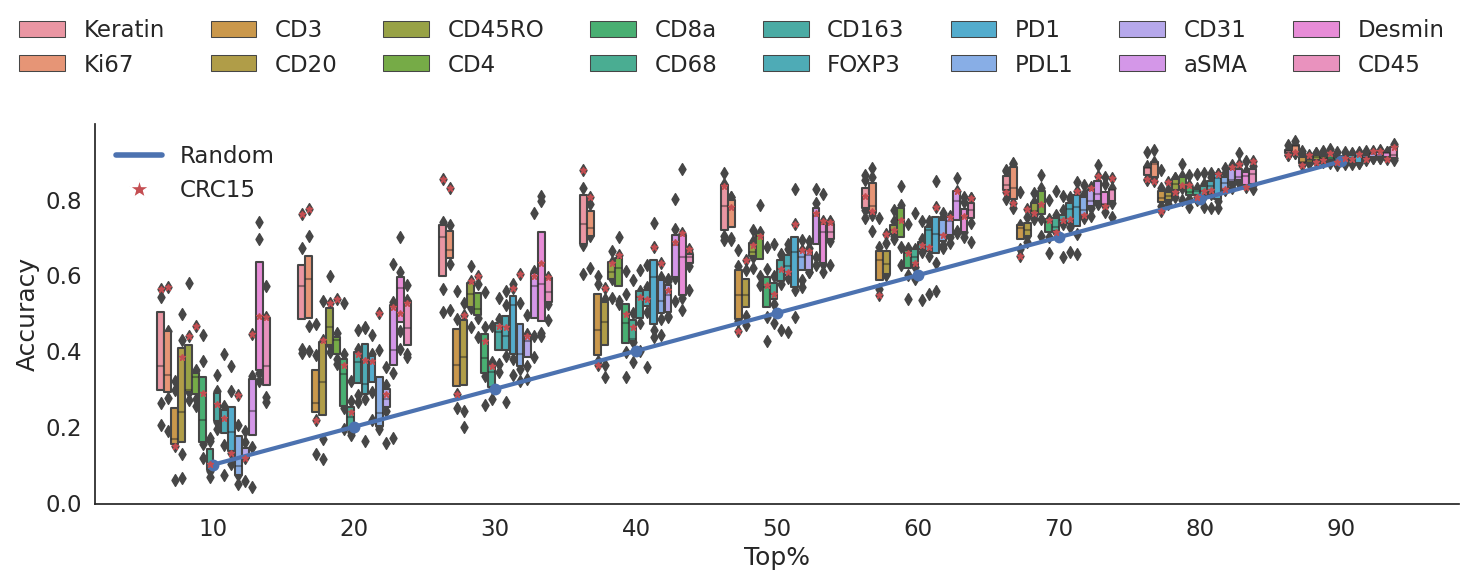

In [117]:
sns.set(font_scale=1.5, style='white')
sample_sets = {'CRC01': [1, 6, 13, 19, 24, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 77, 83, 85, 90, 96, 101, 105],
               'CRC02-17':['CRC02', 'CRC03', 'CRC12', 'CRC13', 'CRC14','CRC15', 'CRC17']}
for set_name, sample_set in sample_sets.items():
    sample_set_df = top_k_acc[top_k_acc.Sample.isin(sample_set)]
    g = sns.catplot(data=sample_set_df, x="Top%", y="Accuracy", hue = 'Marker', kind="boxen", aspect = 3.0)
    sns.move_legend(g, "lower center",bbox_to_anchor=(.45, 1), ncol=8, title=None, frameon=False)
    g.ax.plot([0,1,2,3,4,5,6,7,8],[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], color='b', marker = '.', linewidth=3, markersize=15)
    example_sample = 96 if set_name == 'CRC01' else 'CRC15'
    example_sample = sample_set_df[sample_set_df.Sample == example_sample]
    for i,prot in enumerate(predicted_proteins):
        g.ax.plot(np.arange(0,9) + 0.4 * (2.0*(i + 0.5)/(len(predicted_proteins)) - 1.0), example_sample[example_sample.Marker == prot]['Accuracy'].to_numpy(), color='r', marker = '*', linewidth=0, markersize=5)
    legend_elements = [matplotlib.lines.Line2D([0], [0], color='b', lw=4, label='Random'),
                   matplotlib.lines.Line2D([0], [0], marker='*', color='w', label='CRC01-96' if set_name == 'CRC01' else 'CRC15',
                          markerfacecolor='r', markersize=15),]
    g.ax.legend(handles=legend_elements, loc='upper left', title=None, frameon=False)
    plt.savefig(f'images/top_k_acc_{set_name}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()
sns.set(font_scale=1.0)

# Cooccurence analysis

In [55]:
df_ind = all_measurements_df.set_index(['Sample','x','y'])
measurements_df_quant = pd.read_csv('/home/jupyter/CycifPreprocess/ProcessedData/measurements_binarized.csv')
measurements_df_quant = measurements_df_quant.set_index(['Sample','x','y'])
measurements_df_quant['Split'] = df_ind['Split']
measurements_df_quant = measurements_df_quant.reset_index()
prediction_df_quant = pd.read_csv('/home/jupyter/Projects/cycif/logs/2023-08-15T12-28-44_ssl_vit_mlp8_16channels/predictions_binarized.csv')
prediction_df_quant = prediction_df_quant.set_index(['Sample','x','y'])
prediction_df_quant['Split'] = df_ind['Split']
prediction_df_quant = prediction_df_quant.reset_index()
measurements_df_quant['Sample'] = measurements_df_quant['Sample'].astype(str)
prediction_df_quant['Sample'] = prediction_df_quant['Sample'].astype(str)

/tmp/ipykernel_80518/1967359567.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  measurements_df_quant = pd.read_csv('/home/jupyter/CycifPreprocess/ProcessedData/measurements_binarized.csv')
/tmp/ipykernel_80518/1967359567.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  prediction_df_quant = pd.read_csv('/home/jupyter/Projects/cycif/logs/2023-08-15T12-28-44_ssl_vit_mlp8_16channels/predictions_binarized.csv')


In [100]:
from eval_utils import *
save = True
dfs = {}
for sample in ['96', 'CRC15']:
    figsize = (6,6) if sample == '96' else (7,4.5)
    dfs[sample, "measured"] = measurements_df_quant[measurements_df_quant.Sample == sample]
    dfs[sample, 'predicted'] = prediction_df_quant[prediction_df_quant.Sample == sample]
    for df_type in  ["measured", 'predicted']:
        df_quant_to_plot = dfs[sample, df_type]
        df_quant_to_plot = plot_prot_cooccurrence(df_quant_to_plot, ['CD45'], figsize = figsize, 
                                                palette= {'CD45+': sns.color_palette("tab10")[6], 'Others': sns.color_palette("tab10")[7]},
                                                save = f'images/binary_{sample}_{df_type}_CD45.pdf' if save else None,
                                                hue_order=['CD45+','Others'], legend = df_type == "measured")
        df_quant_to_plot = plot_prot_cooccurrence(df_quant_to_plot, ['CD4', 'FOXP3', 'CD8a'], figsize = figsize, palette= {'Others': sns.color_palette("tab10")[7], 
                                                                                    'CD4+/FOXP3+/CD8a+': sns.color_palette("tab10")[2],
                                                                                    'CD4+/FOXP3+': sns.color_palette("tab10")[6],
                                                                                    'CD8a+': sns.color_palette("tab10")[9]},
                                                save = f'images/binary_{sample}_{df_type}_CD4_FOXP3_CD8a.pdf' if save else None,
                                                hue_order=['CD4+/FOXP3+', 'CD4+/FOXP3+/CD8a+','CD8a+','Others'], legend = df_type == "measured")
        df_quant_to_plot = plot_prot_cooccurrence(df_quant_to_plot, ['PDL1'], figsize = figsize, 
                                                palette= {'PDL1+': sns.color_palette("tab10")[6], 'Others': sns.color_palette("tab10")[7]},
                                                save = f'images/binary_{sample}_{df_type}_PDL1.pdf' if save else None,
                                                hue_order=['PDL1+','Others'], legend = df_type == "measured")
        df_quant_to_plot = plot_prot_cooccurrence(df_quant_to_plot, ['PD1', 'PDL1'], figsize = figsize, palette= {'Others': sns.color_palette("tab10")[7],
                                                                            'PD1+': sns.color_palette("tab10")[9],
                                                                            'PDL1+': sns.color_palette("tab10")[6],
                                                                            'PD1+/PDL1+': sns.color_palette("tab10")[2],},
                                                save = f'images/binary_{sample}_{df_type}_PD1_PDL1.pdf' if save else None,
                                                hue_order=['PDL1+', 'PD1+/PDL1+', 'PD1+','Others'], legend = df_type == "measured")
        df_quant_to_plot = plot_prot_cooccurrence(df_quant_to_plot, ['CD68', 'PDL1', 'CD8a', 'PD1'], figsize = figsize, palette= {'Others': sns.color_palette("tab10")[7],
                                                                            'CD68+/PDL1+': sns.color_palette("tab10")[6],
                                                                            'CD8a+/PD1+': sns.color_palette("tab10")[9],
                                                                            'CD68+/PDL1+/CD8a+/PD1+': sns.color_palette("tab10")[2],},
                                                save = f'images/binary_{sample}_{df_type}_CD68_PDL1_CD8a_PD1.pdf' if save else None,
                                                hue_order=['CD68+/PDL1+','CD68+/PDL1+/CD8a+/PD1+','CD8a+/PD1+','Others'], legend = df_type == "measured")
        print('--------------------')
        dfs[sample, df_type]= df_quant_to_plot

--------------------
--------------------
--------------------
--------------------


#####################
96
CD45 


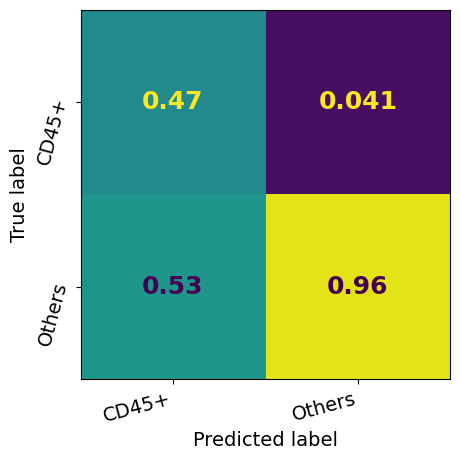

CD45 
-------------
CD4/FOXP3/CD8a


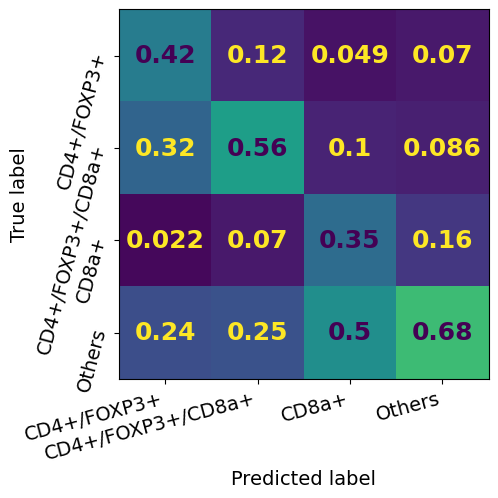

CD4/FOXP3/CD8a
-------------
PDL1 


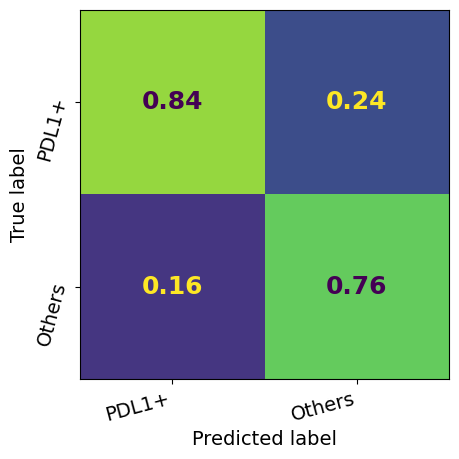

PDL1 
-------------
PD1/PDL1


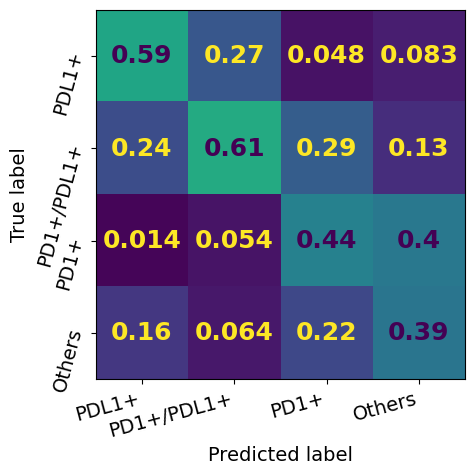

PD1/PDL1
-------------
CD68/PDL1/CD8a/PD1


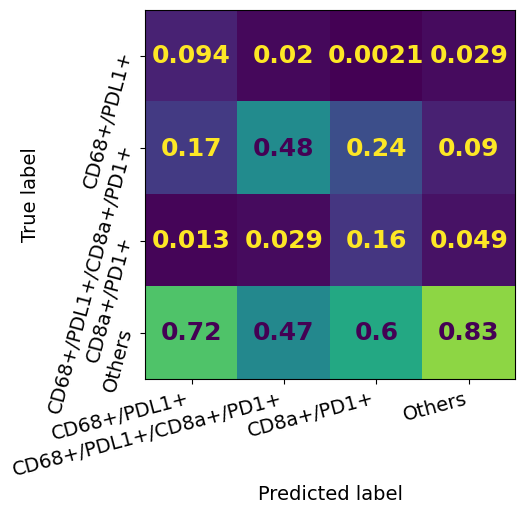

CD68/PDL1/CD8a/PD1
-------------
#####################
CRC15
CD45 


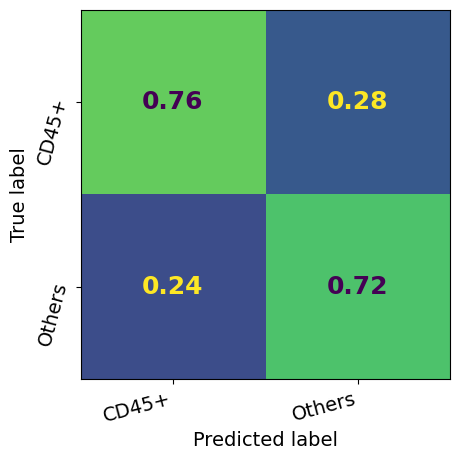

CD45 
-------------
CD4/FOXP3/CD8a


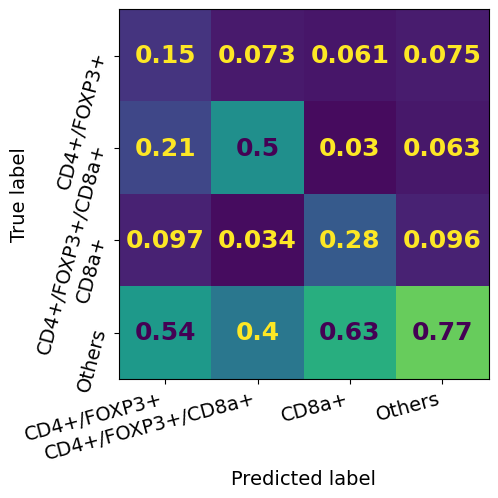

CD4/FOXP3/CD8a
-------------
PDL1 


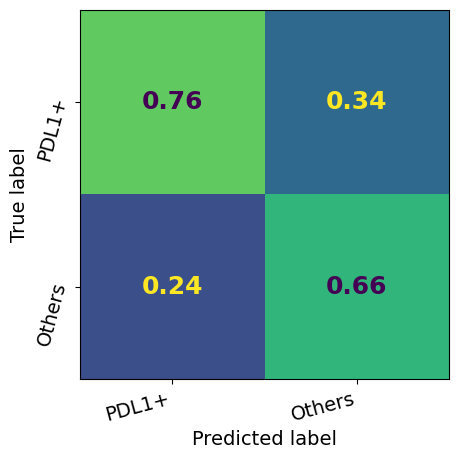

PDL1 
-------------
PD1/PDL1


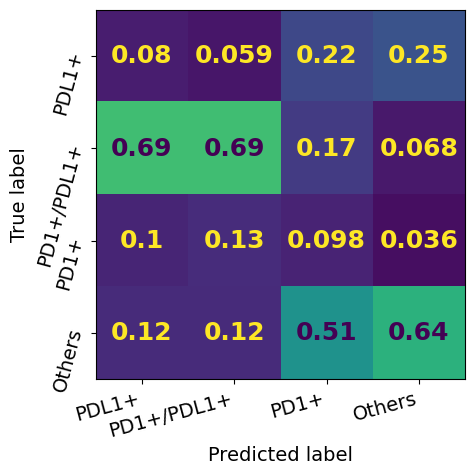

PD1/PDL1
-------------
CD68/PDL1/CD8a/PD1


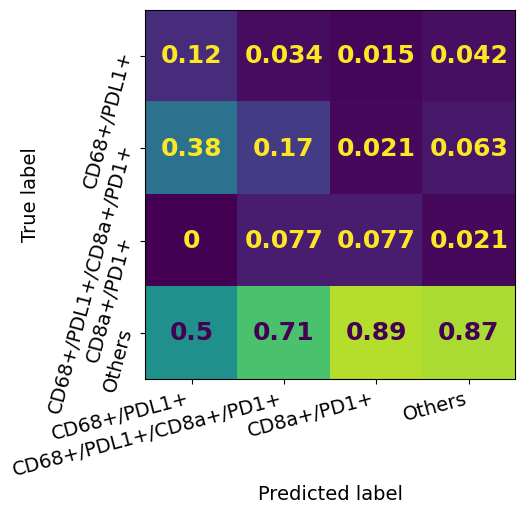

CD68/PDL1/CD8a/PD1
-------------


In [99]:
save = False
sns.reset_orig()
fontsize_org = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 14})
for sample in ['96', 'CRC15']:
    print('#####################')
    print (sample)
    for s in ['CD45 ', 'CD4/FOXP3/CD8a', 'PDL1 ', 'PD1/PDL1', 'CD68/PDL1/CD8a/PD1']:
        print(s)
        label_order = {'CD45 ': ['CD45+','Others'],
                 'CD4/FOXP3/CD8a':['CD4+/FOXP3+', 'CD4+/FOXP3+/CD8a+','CD8a+','Others'],
                 'PDL1 ': ['PDL1+','Others'],
                 'PD1/PDL1': ['PDL1+', 'PD1+/PDL1+', 'PD1+','Others'],
                 'CD68/PDL1/CD8a/PD1': ['CD68+/PDL1+','CD68+/PDL1+/CD8a+/PD1+','CD8a+/PD1+','Others']}  
        disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(dfs[sample, 'measured'][s], dfs[sample, 'predicted'][s],  
                                                                    #    xticks_rotation='vertical',
                                                                    # xticks_rotation=45,
                                                                    # xticks_rotation=15,
                                                                    labels = label_order[s],
                                                                    colorbar=False,
                                                                    normalize='pred') #'all')
        disp.ax_.get_images()[0].set_clim(0, 1)
        for labels in disp.text_.ravel():
            labels.set_fontsize(18)
            labels.set_weight('bold')
        # plt.gca().axes.get_yaxis().set_ticks([])
        deg = 15
        plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=90 - deg, ha='right')
        plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=deg, ha='right')
        s_name = s.replace('/','_')
        if save:
            plt.savefig(f'images/conf_mat_{sample}_{s_name}.pdf', bbox_inches='tight', pad_inches=0)
        plt.show()
        print(s)
        # print(sklearn.metrics.classification_report(dfs[sample, 'measured'][s], dfs[sample, 'predicted'][s]))
        print('-------------')
plt.rcParams.update({'font.size': fontsize_org})

<Axes: xlabel='Predicted label', ylabel='True label'>

In [ ]:
np.random.seed(4)
for s in ['CD45 ', 'CD4/FOXP3/CD8a', 'PDL1 ', 'PD1/PDL1', 'CD68/PDL1/CD8a/PD1']:
    print(s, 'measured vs predicted')
    print(sklearn.metrics.classification_report(dfs['measured'][s].to_numpy(), dfs['predicted'][s].to_numpy(), digits=4))
    print(s, 'measured vs random measured')
    print(sklearn.metrics.classification_report(dfs['measured'][s].to_numpy(), np.random.permutation(dfs['measured'][s].to_numpy()), digits=4))
    print(sklearn.metrics.classification_report(dfs['measured'][s].to_numpy(), np.random.permutation(dfs['measured'][s].to_numpy()), digits=4))
    print(s, 'measured vs random predicted')
    print(sklearn.metrics.classification_report(dfs['measured'][s].to_numpy(), np.random.permutation(dfs['predicted'][s].to_numpy()), digits=4))
    print(sklearn.metrics.classification_report(dfs['measured'][s].to_numpy(), np.random.permutation(dfs['predicted'][s].to_numpy()), digits=4))
    print('-------------')

In [82]:
def and_all_pairs(df, prots = predicted_proteins):
    df = df.copy()
    for p1 in prots:
        for p2 in prots:
            if p1 == p2: continue
            df[f'{p1}+&{p2}+'] = df[p1] & df[p2]
    return df
def proportions_df(df):
    return df.groupby('Sample').sum()/df.groupby('Sample').count()
def read_quant_df_and_get_proportions(name, prots = predicted_proteins):
    df = pd.read_csv(name)
    df['Sample'] = df['Sample'].astype(str)
    df = and_all_pairs(df, prots)
    df_proportions = proportions_df(df)
    for p1 in prots:
        for p2 in prots:
            if p1 == p2: continue
            df_proportions[f'{p1}+|{p2}+'] = df_proportions[f'{p1}+&{p2}+'] / df_proportions[p2]
    df_proportions['Sample'] = df_proportions.index
    df_proportions['Sample_set'] = df_proportions['Sample'].apply(lambda s: 'CRC2-17' if s.startswith('CRC') else 'CRC1')
    return df_proportions

measurements_df_proportions = read_quant_df_and_get_proportions('/home/jupyter/CycifPreprocess/ProcessedData/measurements_binarized.csv')
prediction_df_proportions = read_quant_df_and_get_proportions('/home/jupyter/Projects/cycif/logs/2023-08-15T12-28-44_ssl_vit_mlp8_16channels/predictions_binarized.csv')

/tmp/ipykernel_80518/631780211.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name)
/tmp/ipykernel_80518/631780211.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{p1}+&{p2}+'] = df[p1] & df[p2]
/tmp/ipykernel_80518/631780211.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{p1}+&{p2}+'] = df[p1] & df[p2]
/tmp/ipykernel_80518/631780211.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fr

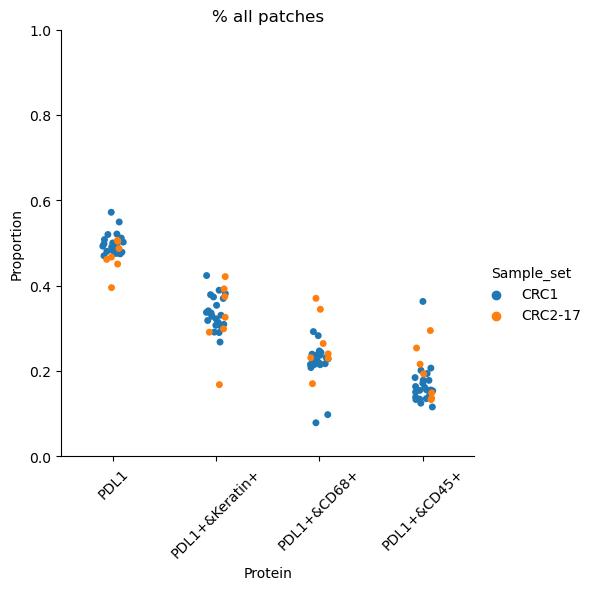

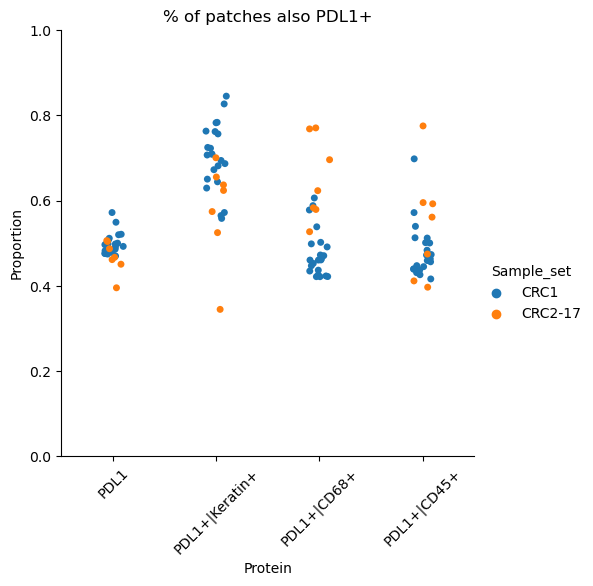

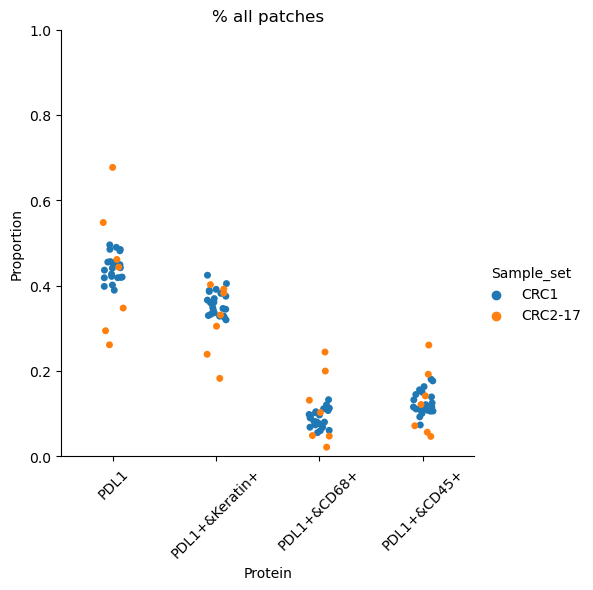

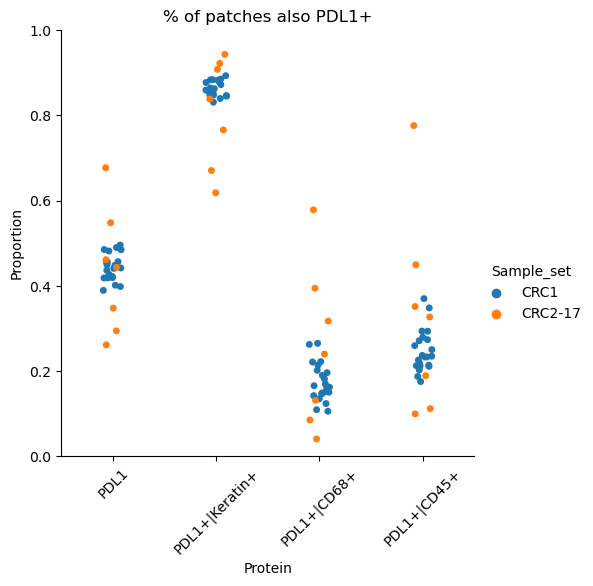

In [83]:
# which_df = prediction_df_proportions # measurements_df_proportions

for which_df in [measurements_df_proportions, prediction_df_proportions]:
        vars = ['PDL1', 'PDL1+&Keratin+', 'PDL1+&CD68+',  'PDL1+&CD45+']
        plot_df = pd.melt(which_df[['Sample', 'Sample_set']+vars], 
                        id_vars=['Sample', 'Sample_set'], 
                value_vars=vars, var_name = 'Protein', value_name = 'Proportion')
        # g = sns.catplot(data=plot_df, x="Protein", y="Proportion", col = 'Sample_set')
        g = sns.catplot(data=plot_df, x="Protein", y="Proportion", hue = 'Sample_set')
        # g = sns.catplot(data=plot_df, x="Protein", y="Proportion", hue = 'Sample_set', kind = 'box')
        g.set_xticklabels(rotation=45)
        plt.title('% all patches')
        plt.ylim([0,1])
        plt.show()

        vars = ['PDL1', 'PDL1+|Keratin+', 'PDL1+|CD68+', 'PDL1+|CD45+']
        plot_df = pd.melt(which_df[['Sample', 'Sample_set']+vars], 
                        id_vars=['Sample', 'Sample_set'], 
                value_vars=vars, var_name = 'Protein', value_name = 'Proportion')
        # g = sns.catplot(data=plot_df, x="Protein", y="Proportion", col = 'Sample_set')
        g = sns.catplot(data=plot_df, x="Protein", y="Proportion", hue = 'Sample_set')
        # g = sns.catplot(data=plot_df, x="Protein", y="Proportion", hue = 'Sample_set', kind = 'box')
        g.set_xticklabels(rotation=45)
        plt.title('% of patches also PDL1+')
        plt.ylim([0,1])
        plt.show()

In [97]:
def power_set(l):
    if len(l) == 0: return [[]]
    pl = power_set(l[1:])
    return [[f'{l[0]}+'] + pl_ for pl_ in pl] + [[f'{l[0]}-'] + pl_ for pl_ in pl]

def read_quant_df_and_all_combinations(file_name, prots = predicted_proteins):
    df = pd.read_csv(file_name)
    df['Sample'] = df['Sample'].astype(str)
    df = df[['Sample', *prots]]
    power_lists = power_set(prots)
    for pl in power_lists:
        col = True
        for s in pl:
            if s[-1] == '+':
                curr = df[s[:-1]]
            else:
                curr = ~df[s[:-1]]
            col = col & curr
        joint_str = '&'.join(pl) if len(pl)>1 else pl[0]
        df[joint_str] = col
    return df.groupby('Sample').sum()
                                

def x_frac_out_y_of_given_z(file_name, x_name, y_name, z_name, save = None, p_values = 'ttest_rel', side = None):
    sns.set(font_scale=1.5, style='white')
    df = read_quant_df_and_all_combinations(file_name, prots = [x_name, y_name, z_name])
    df['Sample'] = df.index
    df['Sample_set'] = df['Sample'].apply(lambda s: 'CRC2-17' if s.startswith('CRC') else 'CRC1')
    df[f'{x_name}+|{y_name}+&{z_name}+'] = df[f'{x_name}+&{y_name}+&{z_name}+'] / (df[f'{x_name}+&{y_name}+&{z_name}+'] + df[f'{x_name}-&{y_name}+&{z_name}+'])
    df[f'{x_name}+|{y_name}+&{z_name}-'] = df[f'{x_name}+&{y_name}+&{z_name}-'] / (df[f'{x_name}+&{y_name}+&{z_name}-'] + df[f'{x_name}-&{y_name}+&{z_name}-'])
    plot_df = pd.melt(df[['Sample', 'Sample_set', f'{x_name}+|{y_name}+&{z_name}+', f'{x_name}+|{y_name}+&{z_name}-']], 
                        id_vars=['Sample', 'Sample_set'], 
                value_vars=[f'{x_name}+|{y_name}+&{z_name}+', f'{x_name}+|{y_name}+&{z_name}-'], var_name = 'Protein', value_name = 'Proportion')
    # # g = sns.catplot(data=plot_df, x="Protein", y="Proportion", col = 'Sample_set')
    # g = sns.catplot(data=plot_df, x="Protein", y="Proportion", col = 'Sample_set', kind = 'point', hue="Sample", palette="tab10")
    # g.set_xticklabels(rotation=45)
    # plt.ylim([0,1])
    # plt.show()
    for sample_set in ['CRC1', 'CRC2-17']:
        set_df = plot_df[plot_df.Sample_set == sample_set]
        g = sns.catplot(data=set_df, 
                        x="Protein", y="Proportion", kind="violin", color=".9", inner=None)
        # g.set_xticklabels(rotation=45)
        g.set(ylim=(0, 1.05))
        # sns.swarmplot(data=set_df, 
        #             x="Protein", y="Proportion" ,size=8)
        pal = {s: sns.color_palette("tab10")[0] for s in set_df.Sample.unique()}
        sns.pointplot(data=set_df,x="Protein", y="Proportion",hue="Sample", palette=pal, scale =0.8)
        plt.gca().get_legend().remove()
        plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=15, ha='center')
        g.set(xlabel='')
        if not p_values is None:
            a = set_df[set_df.Protein == f'{x_name}+|{y_name}+&{z_name}+']['Proportion'].to_numpy()
            b = set_df[set_df.Protein == f'{x_name}+|{y_name}+&{z_name}-']['Proportion'].to_numpy()
            if side is None:
                if x_name == 'Keratin':
                    side = 'less'
                elif x_name == 'CD45':
                    side = 'greater'
                else:
                    side = 'two-sided'
            if p_values == 'wilcoxon':
                print(sample_set, f'{x_name}+|{y_name}+&{z_name}+', side, f'{x_name}+|{y_name}+&{z_name}-', scipy.stats.wilcoxon(a,b, alternative = side))
                pval = scipy.stats.wilcoxon(a,b, alternative = side)[1]
            else:
                print(sample_set, f'{x_name}+|{y_name}+&{z_name}+', side, f'{x_name}+|{y_name}+&{z_name}-', scipy.stats.ttest_rel(a,b, alternative = side))
                pval = scipy.stats.ttest_rel(a,b, alternative = side)[1]
            y = 1.0
            h = 0.04
            plt.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, c='k')
            plt.text(0.5, y+h, f'{pval:.3}', ha='center', va='bottom', color='k')
        if save:
            plt.savefig(f'{save}_{x_name}_frac_out_{y_name}_of_{z_name}_{sample_set}.pdf', bbox_inches='tight', pad_inches=0)
        else:
            plt.show()
    sns.reset_orig()
    return None

save = False

x_frac_out_y_of_given_z('/home/jupyter/CycifPreprocess/ProcessedData/measurements_binarized.csv', 'Keratin', 'PDL1', 'PD1', save = 'images/measured' if save else None)
x_frac_out_y_of_given_z('/home/jupyter/CycifPreprocess/ProcessedData/measurements_binarized.csv', 'CD45', 'PDL1', 'PD1', save = 'images/measured' if save else None)
x_frac_out_y_of_given_z('/home/jupyter/Projects/cycif/logs/2023-08-15T12-28-44_ssl_vit_mlp8_16channels/predictions_binarized.csv', 'Keratin', 'PDL1', 'PD1', save = 'images/predicted' if save else None)
x_frac_out_y_of_given_z('/home/jupyter/Projects/cycif/logs/2023-08-15T12-28-44_ssl_vit_mlp8_16channels/predictions_binarized.csv', 'CD45', 'PDL1', 'PD1', save = 'images/predicted' if save else None)

/tmp/ipykernel_80518/2508420027.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


CRC1 Keratin+|PDL1+&PD1+ less Keratin+|PDL1+&PD1- TtestResult(statistic=-3.8350484368277105, pvalue=0.00048155965157238307, df=21)
CRC2-17 Keratin+|PDL1+&PD1+ less Keratin+|PDL1+&PD1- TtestResult(statistic=3.4182388434412325, pvalue=0.9929128163313179, df=6)


/tmp/ipykernel_80518/2508420027.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


CRC1 CD45+|PDL1+&PD1+ greater CD45+|PDL1+&PD1- TtestResult(statistic=5.8996011540856435, pvalue=3.711733542492015e-06, df=21)
CRC2-17 CD45+|PDL1+&PD1+ greater CD45+|PDL1+&PD1- TtestResult(statistic=-0.34447158804274713, pvalue=0.6288777843193525, df=6)


/tmp/ipykernel_80518/2508420027.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


CRC1 Keratin+|PDL1+&PD1+ less Keratin+|PDL1+&PD1- TtestResult(statistic=-16.272608758817505, pvalue=1.1076508407252947e-13, df=21)
CRC2-17 Keratin+|PDL1+&PD1+ less Keratin+|PDL1+&PD1- TtestResult(statistic=-2.316609159240159, pvalue=0.0298628321990656, df=6)


/tmp/ipykernel_80518/2508420027.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


CRC1 CD45+|PDL1+&PD1+ greater CD45+|PDL1+&PD1- TtestResult(statistic=21.889394201436797, pvalue=3.0613477699055475e-16, df=21)
CRC2-17 CD45+|PDL1+&PD1+ greater CD45+|PDL1+&PD1- TtestResult(statistic=3.013085441014697, pvalue=0.011803224640657339, df=6)


In [2]:
df = pd.read_csv('/home/jupyter/CycifPreprocess/ProcessedData/sample_patches_measurements_with_cells_gating_channels_test.csv')

In [5]:
df['Sample'].value_counts()

Sample
13     20019
1      19522
33     19471
6      19247
48     19088
63     18621
53     17877
19     17709
24     17547
101    17409
28     17385
58     17160
43     17099
105    17070
85     17010
90     16969
68     15653
96     15479
83     15465
38     15046
77     14671
73     13625
Name: count, dtype: int64

In [6]:
sample_num = 73
sub_df = df[df['Sample'] == sample_num]
dir = '/home/jupyter/CycifPreprocess/Crops/'
sample_cols = ['Sample', 'x', 'y']
sample_str = f'WD-76845-{sample_num:03}'
# img_path = os.path.join(dir, sample_str, f'{sample_str}_{x}_{y}.png')

In [8]:
sub_df.to_csv(f'/home/jupyter/CycifPreprocess/ProcessedData/{sample_str}_patches_measurements_with_cells_gating_channels_test.csv', index = False)

In [10]:
import shutil

for i, row in sub_df.iterrows():
    x, y = int(row['x']), int(row['y'])
    file_name = f'{sample_str}_{x}_{y}.png'
    img_path = os.path.join(f'/home/jupyter/CycifPreprocess/Crops/{sample_str}', file_name)
    shutil.copyfile(img_path, f'/home/jupyter/CycifPreprocess/Crops/{sample_str}-test/{file_name}')
